In [17]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import json
import seaborn as sns

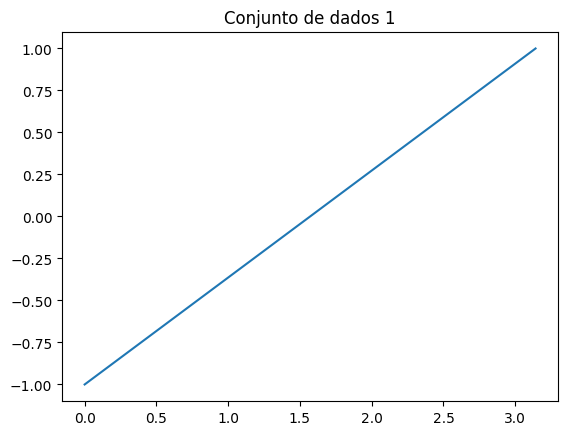

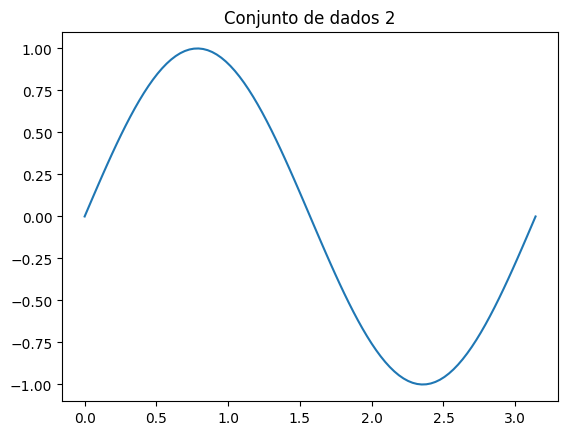

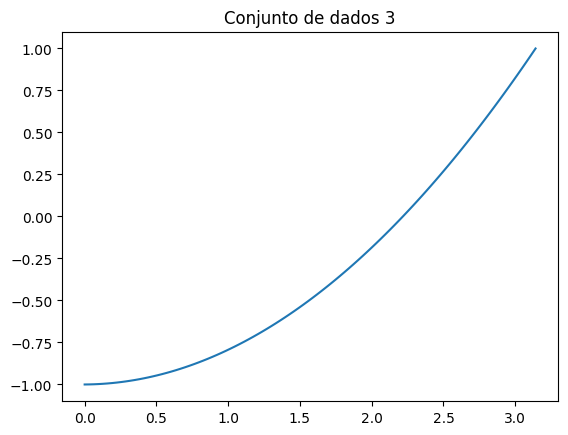

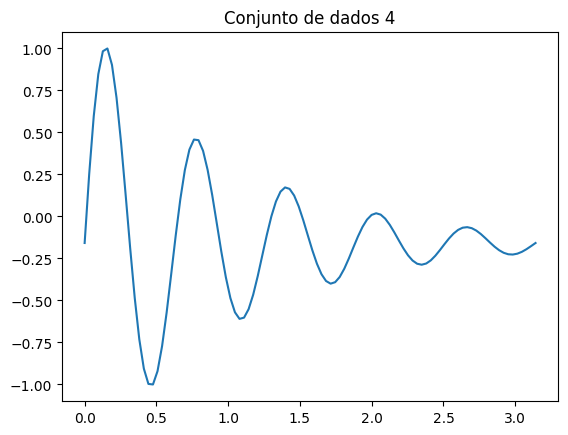

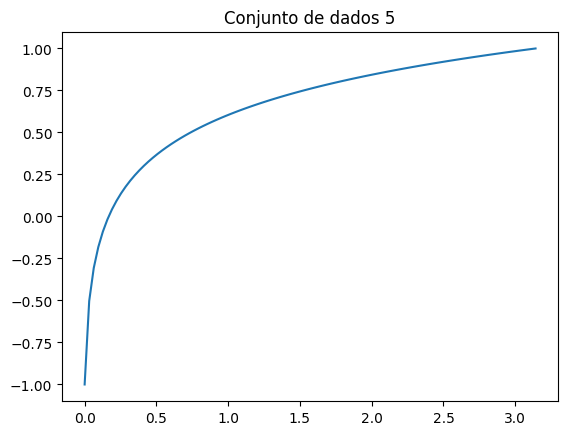

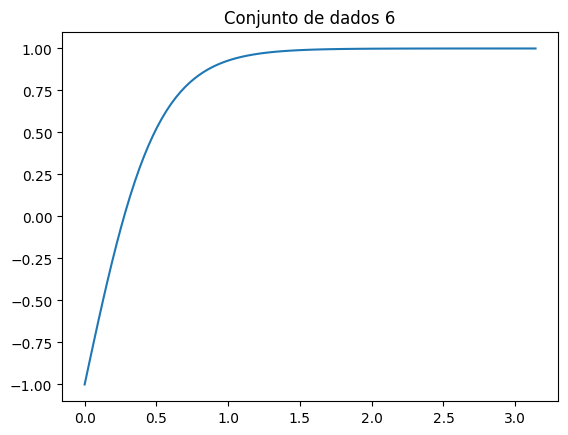

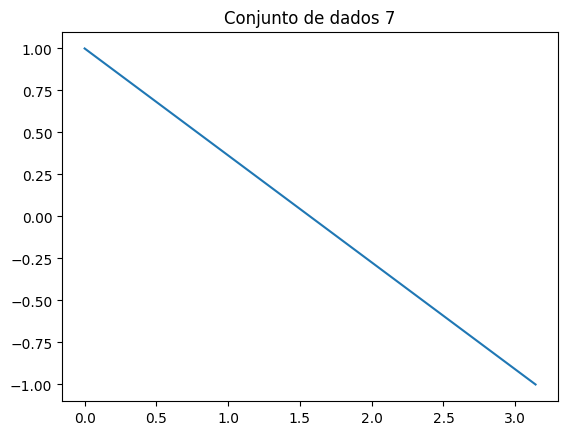

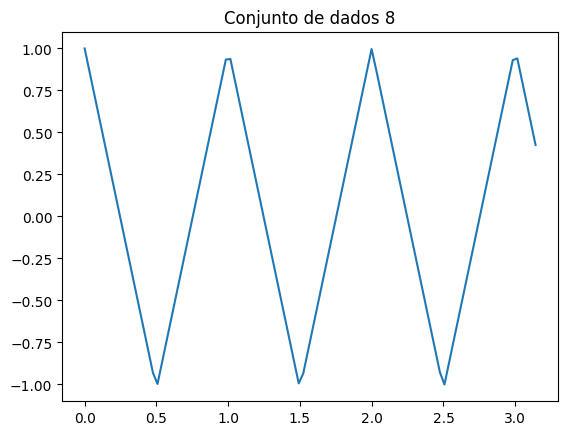

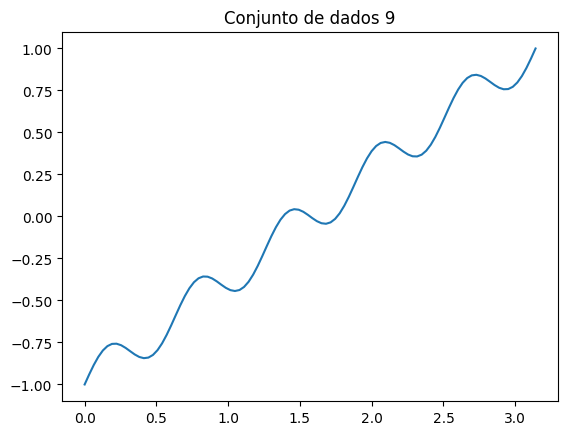

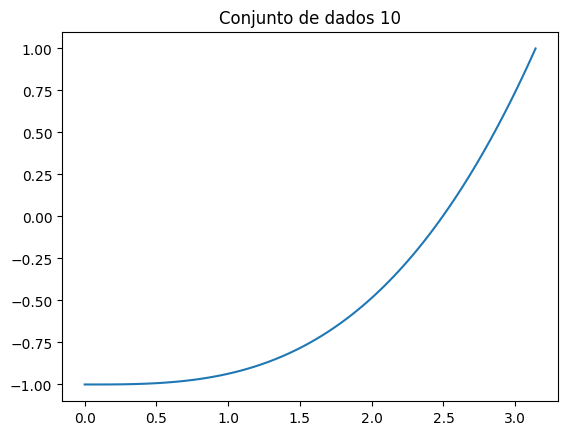

In [2]:
funcs = {
    0: lambda x: 2 * x + 1, # Linearidade simples
    1: lambda x: np.sin(x / 50), # Periodicidade
    2: lambda x: x**2 + 3 * x + 2, # Não linear com tendência crescente
    3: lambda x: np.exp(-x / 100) * np.sin(x / 10),  # damped sine wave
    4: lambda x: np.log1p(np.abs(x)),               # log-based growth
    5: lambda x: np.tanh(x / 50),                   # sigmoid-like nonlinearity
    6: lambda x: np.piecewise(x, [x < 0, x >= 0], [lambda x: x**2, lambda x: -x]),  # piecewise
    7: lambda x: np.abs(x % 100 - 50),              # triangular wave
    8: lambda x: 10 * np.sin(x / 10) + 0.5 * x,     # trend + periodicity
    9: lambda x: (x / 10)**3 - (x / 10),            # cubic polynomial
}

def min_max_norm(dataset):
    norm_dataset = {}
    X = dataset["x"] 
    Y = dataset["y"] 

    norm_dataset["x"] = ((X - np.min(X)) / (np.max(X) - np.min(X))) *np.pi
    norm_dataset["y"] = (Y - np.min(Y)) / (np.max(Y) - np.min(Y)) *2 -1

    return norm_dataset

def generate_dataset(func, x_min=0, x_max=100 * np.pi, num_samples=100):

    X = np.linspace(x_min, x_max, num_samples)
    y = func(X)
    return X, y

datasets = {}

for i in funcs:
    x, y = generate_dataset(funcs[i])
    datasets[i] = {}
    datasets[i]["x"] = x
    datasets[i]["y"] = y

    datasets[i] = min_max_norm(datasets[i])

for i in datasets:
    plt.title(f"Conjunto de dados {i+1}")
    plt.plot(datasets[i]['x'], datasets[i]['y'])
    plt.show()

In [3]:
class QuantumRegressor(object):
    def __init__(self, n_qubits=1, n_layers=3, dataset_idx = 0, qaoa_weights = None, embedding_time = None):
        """
        Initialize the QuantumRegressor.

        Inputs:
            n_qubits (int): Number of qubits to use in the quantum circuit.
            n_layers (int): Number of layers in the quantum circuit.

        Outputs:
            None
        """
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.device = qml.device('lightning.qubit', wires=self.n_qubits)
        self.embedding_device = qml.device('lightning.qubit', wires=self.n_qubits)
        self.training_time = None
        self.circuit_depth = self._calculate_circuit_depth()
        self.training_time = -1
        self.dataset_idx = dataset_idx
        self.qaoa_weights = qaoa_weights
        
        if embedding_time is None:
            self.embedding_time = -1
        else:
            self.embedding_time = embedding_time

        if self.n_qubits > 1:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=self.n_layers, n_wires=self.n_qubits)
            self.parameters = 0.01 * np.random.randn(*shape, requires_grad=True)
        else:
            self.parameters = 0.01 * np.random.randn(self.n_layers, 3, requires_grad=True)

        self.bias = np.array(0.0, requires_grad=True)


        @qml.qnode(self.embedding_device)
        def qaoa_circuit(weights, features):
            qml.QAOAEmbedding(features = features, weights = weights, wires = range(self.n_qubits), local_field='Y')
            return qml.expval(qml.PauliZ(0))
        self.qaoa_emb = qaoa_circuit    
        
            
        @qml.qnode(self.device)
        def quantum_circuit(params, x_input):
            """
            Quantum circuit for regression.

            Inputs:
                params (np.ndarray): Parameters for the quantum gates.
                x_input (np.ndarray): Input features, should have length equal to n_qubits.

            Outputs:
                float: Expectation value of PauliZ on wire 0.
            """
            if len(x_input) != self.n_qubits:
                raise ValueError(f"Input must have exactly {self.n_qubits} features, got {len(x_input)}")
            
            # Embedding!
            
            features = np.array(x_input)
            if self.qaoa_weights is None:
                raise Exception("É necessário treinar o embedding antes")
            qml.QAOAEmbedding(features = features, weights = self.qaoa_weights, wires=range(self.n_qubits), local_field='Y')
            
            
            if self.n_qubits > 1:
                qml.StronglyEntanglingLayers(weights=params, wires=range(self.n_qubits))
            else:
                for i in range(self.n_layers):
                    qml.Rot(*params[i], wires=0)
            return qml.expval(qml.PauliZ(0))
        self.qnode = quantum_circuit

        
    def _calculate_circuit_depth(self):
        """
        Calculate the depth of the quantum circuit.

        Inputs:
            None

        Outputs:
            int: The depth of the quantum circuit.
        """
        embedding_depth = 1
        if self.n_qubits > 1:
            processing_depth = self.n_layers * 2
        else:
            processing_depth = self.n_layers
        return embedding_depth + processing_depth

    @staticmethod
    def loss_fn(y_true, y_pred):
        """
        Compute the mean absolute error loss.

        Inputs:
            y_true (np.ndarray): True target values.
            y_pred (np.ndarray or list): Predicted values.

        Outputs:
            float: Mean absolute error between y_true and y_pred.
        """
        return np.mean(np.abs(y_true - y_pred))

    def compute_loss(self, X, y, params=None, bias=None):
        """
        Compute the loss for a given dataset and parameters.

        Inputs:
            X (np.ndarray): Input features, shape (num_samples, num_features).
            y (np.ndarray): Target values.
            params (np.ndarray, optional): Parameters for the quantum circuit. If None, uses self.parameters.
            bias (np.ndarray, optional): Bias term. If None, uses self.bias.

        Outputs:
            float: Computed loss value.
        """
        if params is None:
            params = self.parameters
        if bias is None:
            bias = self.bias
        if X.shape[1] > self.n_qubits:
            raise ValueError(f"Input features must have less than {self.n_qubits} columns, got {X.shape[1]}")
        y_pred = np.array([self.qnode(params, x) + bias for x in X])
        return self.loss_fn(y, y_pred)

    def forward(self, x_input, params=None, bias=None):
        """
        Perform a forward pass through the quantum circuit.

        Inputs:
            x_input (np.ndarray): Input features, length should be n_qubits.
            params (np.ndarray, optional): Parameters for the quantum circuit. If None, uses self.parameters.
            bias (np.ndarray, optional): Bias term. If None, uses self.bias.

        Outputs:
            float: Predicted value for the input.
        """
        if params is None:
            params = self.parameters
        if bias is None:
            bias = self.bias
        if len(x_input) != self.n_qubits:
            raise ValueError(f"Input must have exactly {self.n_qubits} features, got {len(x_input)}")
        return self.qnode(params, x_input) + bias

    def predict_single(self, x_input):
        """
        Predict the output for a single input value.

        Inputs:
            x_input (np.ndarray): Input features, length should be n_qubits.

        Outputs:
            float: Predicted value for the input.
        """
        return self.forward(x_input)

    def plot_circuit(self, expand_layers=True):
        """
        Plot the quantum circuit using matplotlib.

        Inputs:
            expand_layers (bool): If True, expands the StronglyEntanglingLayers to show individual gates.
                                  If False, shows the compact representation.

        Outputs:
            None
        """
        features = np.ones(self.n_qubits)
        if expand_layers:
            @qml.qnode(self.device)
            def expanded_circuit(params, x_input):
                features = np.array(x_input)
                shape = qml.QAOAEmbedding.shape(n_layers = self.n_layers, n_wires = self.n_qubits)
                weights = np.random.random(shape)
                qml.QAOAEmbedding(features=features, weights = weights, wires=range(self.n_qubits), local_field='Y')
                if self.n_qubits > 1:
                    for layer in range(self.n_layers):
                        for wire in range(self.n_qubits):
                            qml.Rot(*params[layer, wire, :3], wires=wire)
                        for wire in range(self.n_qubits - 1):
                            qml.CNOT(wires=[wire, wire + 1])
                        if self.n_qubits > 2:
                            qml.CNOT(wires=[self.n_qubits - 1, 0])
                else:
                    for i in range(self.n_layers):
                        qml.Rot(*params[i], wires=0)
                return qml.expval(qml.PauliZ(0))
            fig, ax = qml.draw_mpl(expanded_circuit)(self.parameters, features)
        else:
            fig, ax = qml.draw_mpl(self.qnode)(self.parameters, features)
        plt.show()

    def predict(self, X):
        """
        Predict outputs for multiple input samples.

        Inputs:
            X (np.ndarray): Input features, shape (num_samples, num_features).

        Outputs:
            list: List of predicted values for each input sample.
        """
        if X.shape[1] > self.n_qubits:
            raise ValueError(f"Input features must have less than {self.n_qubits} columns, got {X.shape[1]}")
        return [self.forward(x) for x in X]

    def batch_loss(self, params, bias, X_batch, y_batch):
        """
        Compute the loss for a batch of data.

        Inputs:
            params (np.ndarray): Parameters for the quantum circuit.
            bias (np.ndarray): Bias term.
            X_batch (np.ndarray): Batch of input features.
            y_batch (np.ndarray): Batch of target values.

        Outputs:
            float: Computed loss value for the batch.
        """
        return self.compute_loss(X_batch, y_batch, params, bias)

    def qaoa_loss(self, weights, features):
        return np.sum([self.qaoa_emb(weights, x) for x in features])
    
    def qaoa_embedding_fit(self, features, epochs=100, learning_rate=0.01):
        shape = qml.QAOAEmbedding.shape(n_layers = self.n_layers, n_wires = self.n_qubits)
        weights = np.random.random(shape)
        
        opt = qml.GradientDescentOptimizer(learning_rate)
        start_time = time.time()
        for i in tqdm(range(epochs),desc=f"Embedding ({self.n_qubits}×{self.n_layers}) Training"):
            weights = opt.step(lambda w: self.qaoa_loss(w, features), weights)
        end_time = time.time()
        self.embedding_time = end_time - start_time
        return weights
        
    def fit(self, X, y, epochs=100, batch_size=10, learning_rate=0.01):
        """
        Train the model on data (X, y) using NesterovMomentumOptimizer.

        Inputs:
            X (np.ndarray): Input features, shape (num_samples, num_features).
            y (np.ndarray): Target values.
            epochs (int): Number of training epochs.
            batch_size (int): Size of each training batch.
            learning_rate (float): Learning rate for the optimizer.

        Outputs:
            None
        """
        # if X.shape[1] != self.n_qubits:
        #     raise ValueError(f"Input features must have {self.n_qubits} columns, got {X.shape[1]}")
        optimizer = NesterovMomentumOptimizer(learning_rate)
        if self.qaoa_weights is None:
            self.qaoa_weights = self.qaoa_embedding_fit(X)
        params = self.parameters
        bias = self.bias
        n_samples = X.shape[0]
        best_params = params.copy()
        best_bias = bias.copy()
        best_loss = float('inf')
        start_time = time.time()
        with tqdm(range(epochs), desc=f"Model ({self.n_qubits}×{self.n_layers}) Training") as pbar:
            for epoch in pbar:
                actual_batch_size = min(batch_size, n_samples)
                batch_indices = np.random.choice(n_samples, actual_batch_size, replace=False)
                X_batch = X[batch_indices, :]
                y_batch = y[batch_indices]
                params, bias, _, _ = optimizer.step(
                    self.batch_loss, params, bias, X_batch, y_batch
                )
                loss = self.compute_loss(X, y, params, bias)
                pbar.set_postfix({"loss": f"{loss:.6f}"})
                if loss < best_loss:
                    best_loss = loss
                    best_params = params.copy()
                    best_bias = bias.copy()
        end_time = time.time()
        self.training_time = end_time - start_time
        self.parameters = best_params
        self.bias = best_bias

    def stats(self, y_pred, y_true, verbose=True):
        """
        Calculate and display statistics for the quantum regressor.

        Inputs:
            y_pred (array-like): Predicted values from the model.
            y_true (array-like): True/actual target values.
            verbose (bool, optional): Whether to print results to console.

        Outputs:
            dict: Dictionary containing calculated metrics (MSE, R2 score, training time, number of qubits, circuit depth).
        """
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        results = {
            'Dataset_Index': self.dataset_idx,
            'MSE': mse,
            'R2_Score': r2,
            'Training_Time': self.training_time,
            'N_Qubits': self.n_qubits,
            'N_layers':self.n_layers,
            'Circuit_Depth': self.circuit_depth,
            'Embedding_Time': self.embedding_time
        }
        spaces = 80
        if verbose:
            print(f"""
                    {'='*spaces}
                    QUANTUM REGRESSOR STATISTICS
                    {'='*spaces}
                    {'Metric':<25} {'Value':<20} {'Description'}
                    {'-'*spaces}
                    {'Mean Squared Error (MSE)':<25} {mse:<20.6f} {'Mean squared error of prediction'}
                    {'R² Score':<25} {r2:<20.6f} {'Coefficient of determination'}
                    {'Training Time (s)':<25} {self.training_time:<20.6f} {'Total training time'}
                    {'Number of Qubits':<25} {self.n_qubits:<20} {'Required resources'}
                    {'Number of Layers':<25} {self.n_layers:<20} {'Required resources'}
                    {'Circuit Depth':<25} {self.circuit_depth:<20} {'Generated circuit complexity'}
                    {'='*spaces}
                    """)
        return results


In [4]:
def write_csv(dict_list):
    with open('result_lightning_2.json', 'a') as json_file:
        json.dump(dict_list, json_file, indent=4)
    df = pd.DataFrame.from_dict(dict_list)
    df.to_csv("qaoa_lightning_2.csv", index=False)
    return df

Model (4×4) Training: 100%|██████████| 500/500 [12:10<00:00,  1.46s/it, loss=0.324884]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.238295             Mean squared error of prediction
                    R² Score                  0.299271             Coefficient of determination
                    Training Time (s)         730.340064           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


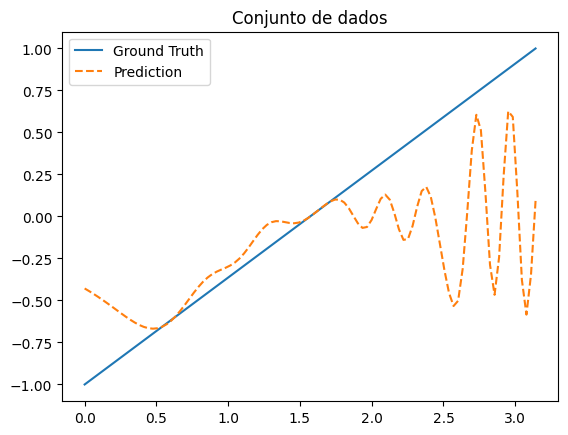

Model (4×4) Training: 100%|██████████| 500/500 [11:09<00:00,  1.34s/it, loss=0.480428]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.367280             Mean squared error of prediction
                    R² Score                  0.258208             Coefficient of determination
                    Training Time (s)         669.634763           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


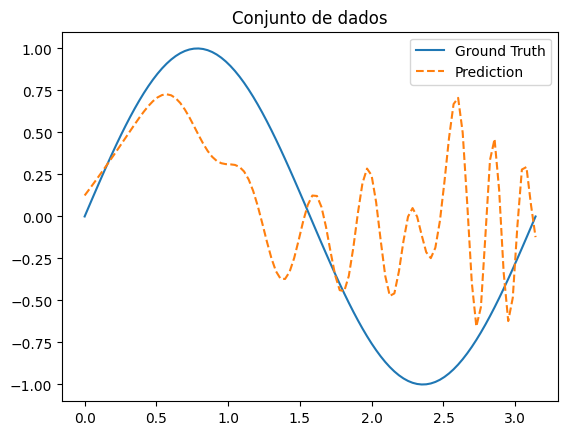

Model (4×4) Training: 100%|██████████| 500/500 [11:00<00:00,  1.32s/it, loss=0.315374]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.252024             Mean squared error of prediction
                    R² Score                  0.305250             Coefficient of determination
                    Training Time (s)         660.172539           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


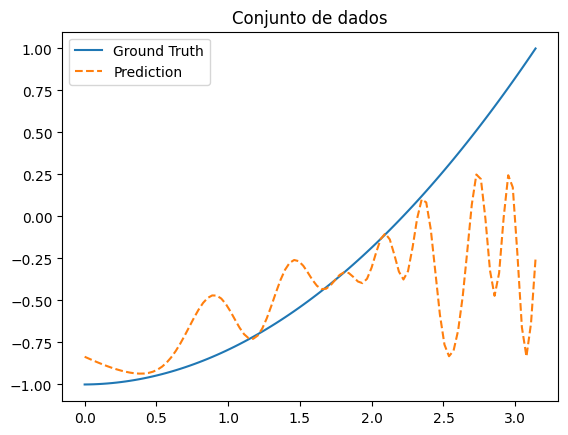

Model (4×4) Training: 100%|██████████| 500/500 [11:53<00:00,  1.43s/it, loss=0.198174]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.097141             Mean squared error of prediction
                    R² Score                  0.314820             Coefficient of determination
                    Training Time (s)         713.707414           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


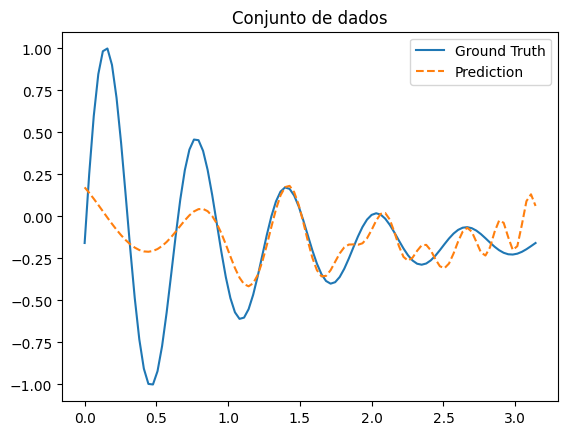

Model (4×4) Training: 100%|██████████| 500/500 [11:58<00:00,  1.44s/it, loss=0.118075]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.054168             Mean squared error of prediction
                    R² Score                  0.562447             Coefficient of determination
                    Training Time (s)         718.193989           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


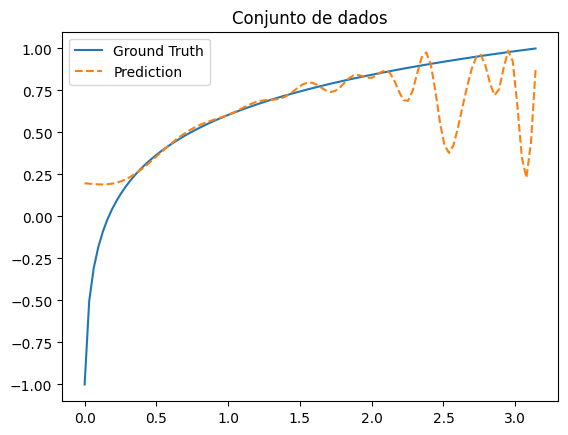

Model (4×4) Training: 100%|██████████| 500/500 [11:56<00:00,  1.43s/it, loss=0.161897]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.095654             Mean squared error of prediction
                    R² Score                  0.548080             Coefficient of determination
                    Training Time (s)         716.904282           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


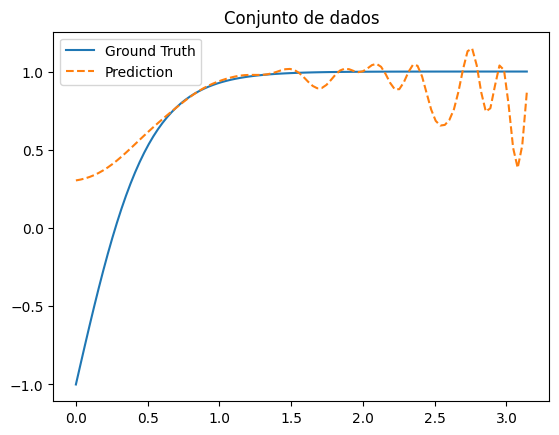

Model (4×4) Training: 100%|██████████| 500/500 [11:53<00:00,  1.43s/it, loss=0.321595]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.221311             Mean squared error of prediction
                    R² Score                  0.349213             Coefficient of determination
                    Training Time (s)         713.415998           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


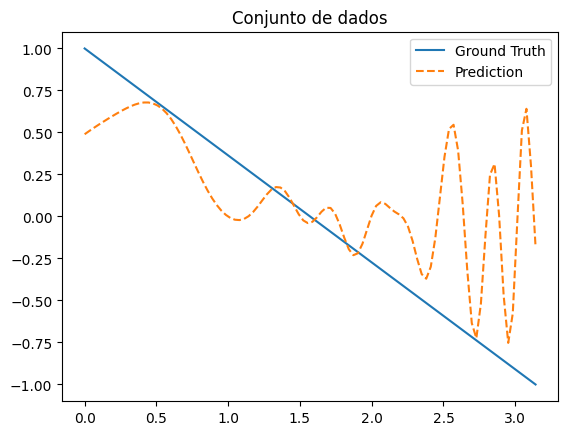

Model (4×4) Training: 100%|██████████| 500/500 [11:51<00:00,  1.42s/it, loss=0.338052]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.195915             Mean squared error of prediction
                    R² Score                  0.445477             Coefficient of determination
                    Training Time (s)         711.662864           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


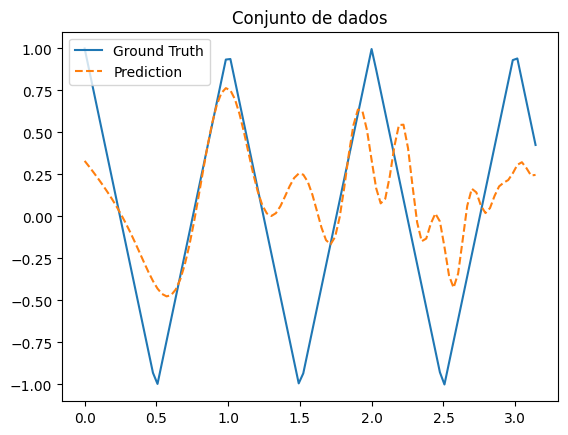

Model (4×4) Training: 100%|██████████| 500/500 [11:50<00:00,  1.42s/it, loss=0.300579]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.221549             Mean squared error of prediction
                    R² Score                  0.333040             Coefficient of determination
                    Training Time (s)         710.935510           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


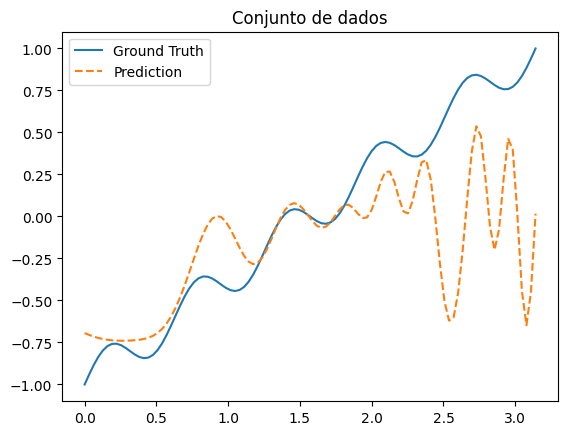

Model (4×4) Training: 100%|██████████| 500/500 [11:52<00:00,  1.42s/it, loss=0.285503]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.245931             Mean squared error of prediction
                    R² Score                  0.256738             Coefficient of determination
                    Training Time (s)         712.329906           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


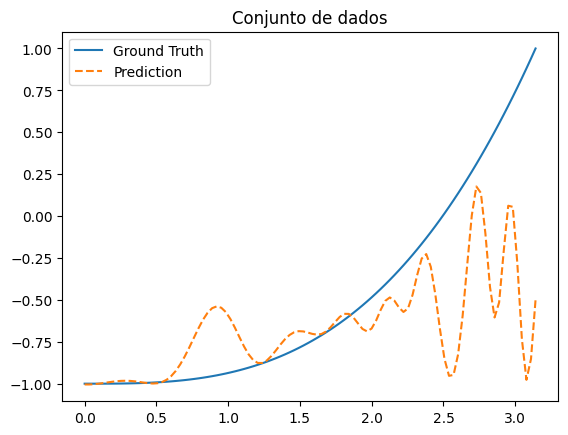

Model (4×5) Training: 100%|██████████| 500/500 [14:30<00:00,  1.74s/it, loss=0.262159]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.156148             Mean squared error of prediction
                    R² Score                  0.540831             Coefficient of determination
                    Training Time (s)         870.726304           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


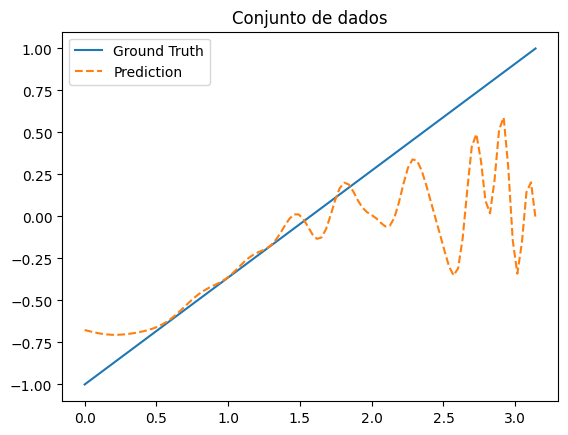

Model (4×5) Training: 100%|██████████| 500/500 [14:29<00:00,  1.74s/it, loss=0.365906]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.228056             Mean squared error of prediction
                    R² Score                  0.539396             Coefficient of determination
                    Training Time (s)         869.809701           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


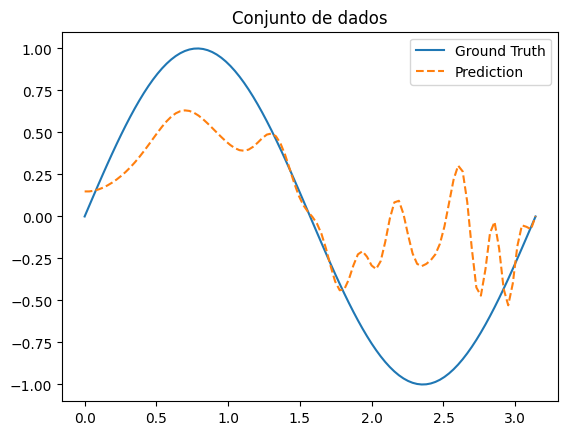

Model (4×5) Training: 100%|██████████| 500/500 [14:31<00:00,  1.74s/it, loss=0.258061]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.206453             Mean squared error of prediction
                    R² Score                  0.430874             Coefficient of determination
                    Training Time (s)         871.571374           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


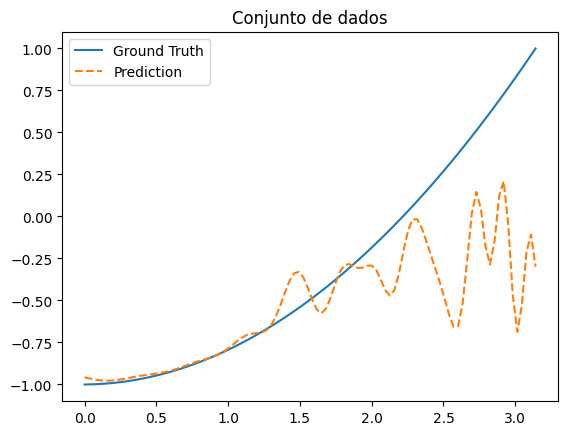

Model (4×5) Training: 100%|██████████| 500/500 [14:32<00:00,  1.74s/it, loss=0.193058]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.117470             Mean squared error of prediction
                    R² Score                  0.171425             Coefficient of determination
                    Training Time (s)         872.307754           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


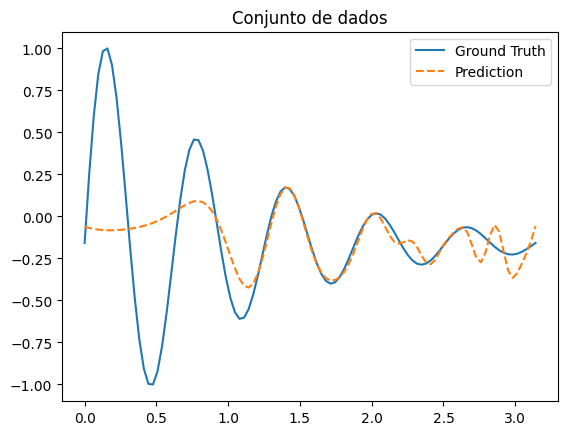

Model (4×5) Training: 100%|██████████| 500/500 [14:33<00:00,  1.75s/it, loss=0.120078]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.054704             Mean squared error of prediction
                    R² Score                  0.558120             Coefficient of determination
                    Training Time (s)         873.594821           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


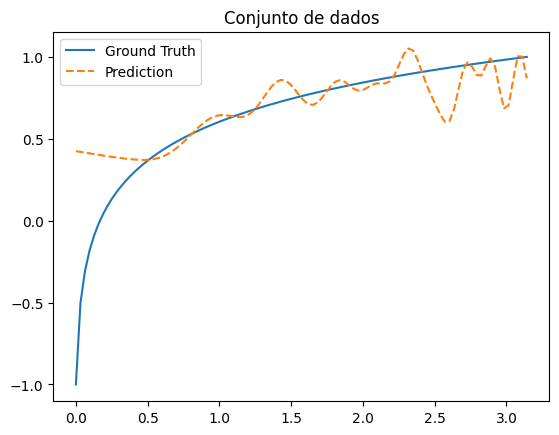

Model (4×5) Training: 100%|██████████| 500/500 [14:53<00:00,  1.79s/it, loss=0.168663]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.121963             Mean squared error of prediction
                    R² Score                  0.423782             Coefficient of determination
                    Training Time (s)         893.201864           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


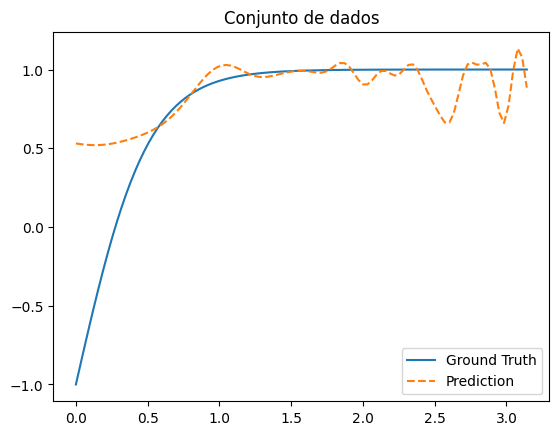

Model (4×5) Training: 100%|██████████| 500/500 [14:41<00:00,  1.76s/it, loss=0.280783]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.164349             Mean squared error of prediction
                    R² Score                  0.516717             Coefficient of determination
                    Training Time (s)         881.761650           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


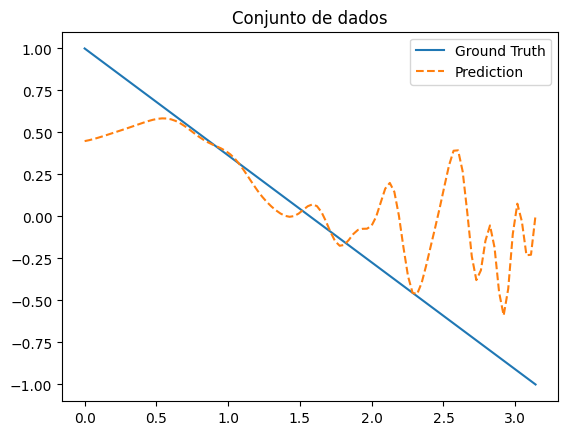

Model (4×5) Training: 100%|██████████| 500/500 [14:46<00:00,  1.77s/it, loss=0.265670]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.140817             Mean squared error of prediction
                    R² Score                  0.601427             Coefficient of determination
                    Training Time (s)         886.276237           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


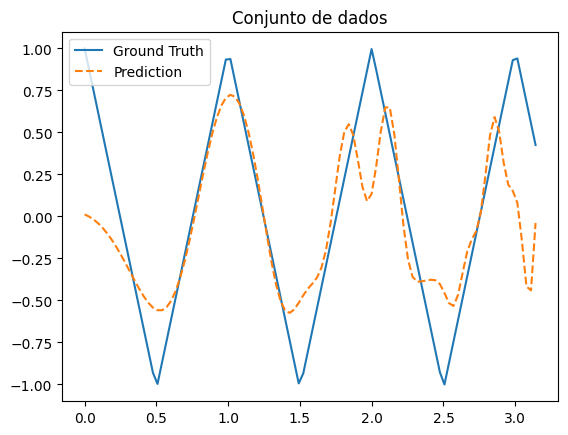

Model (4×5) Training: 100%|██████████| 500/500 [14:57<00:00,  1.80s/it, loss=0.280428]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.166212             Mean squared error of prediction
                    R² Score                  0.499630             Coefficient of determination
                    Training Time (s)         897.802548           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


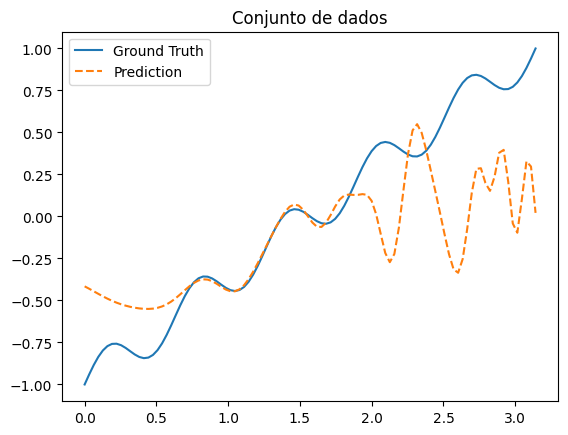

Model (4×5) Training: 100%|██████████| 500/500 [14:53<00:00,  1.79s/it, loss=0.229303]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.184874             Mean squared error of prediction
                    R² Score                  0.441266             Coefficient of determination
                    Training Time (s)         893.245797           Total training time
                    Number of Qubits          4                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


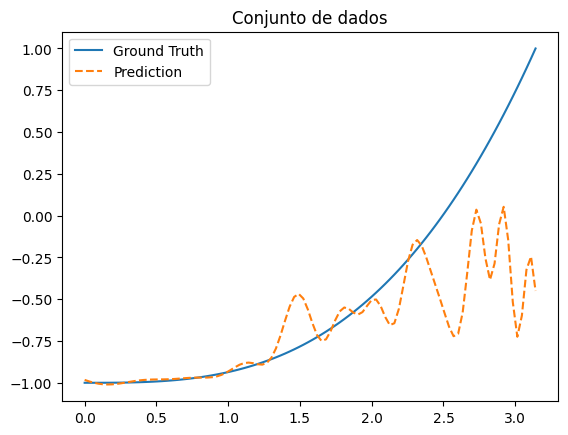

Model (5×4) Training: 100%|██████████| 500/500 [14:48<00:00,  1.78s/it, loss=0.363718]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.189349             Mean squared error of prediction
                    R² Score                  0.443200             Coefficient of determination
                    Training Time (s)         888.809870           Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


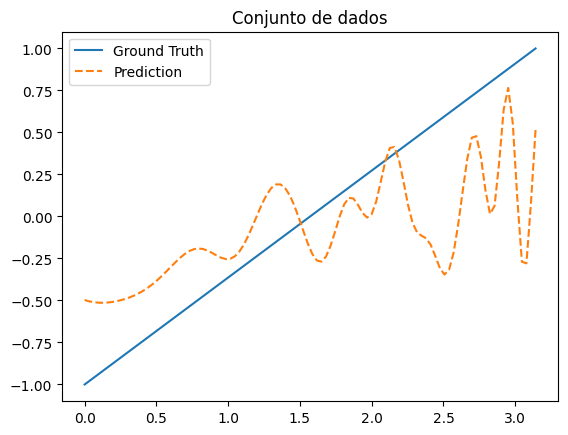

Model (5×4) Training: 100%|██████████| 500/500 [14:49<00:00,  1.78s/it, loss=0.531666]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.370195             Mean squared error of prediction
                    R² Score                  0.252319             Coefficient of determination
                    Training Time (s)         889.748741           Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


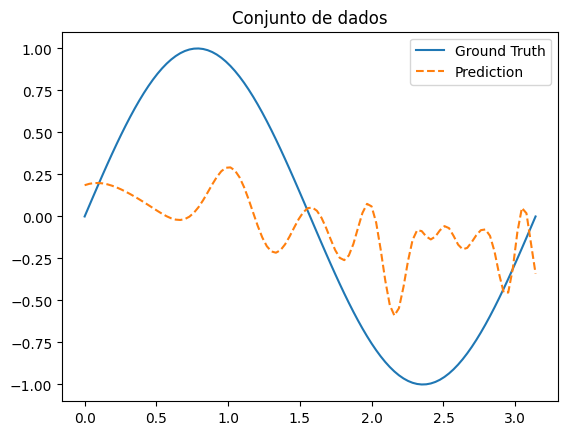

Model (5×4) Training: 100%|██████████| 500/500 [14:52<00:00,  1.79s/it, loss=0.358337]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.274553             Mean squared error of prediction
                    R² Score                  0.243143             Coefficient of determination
                    Training Time (s)         892.522825           Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


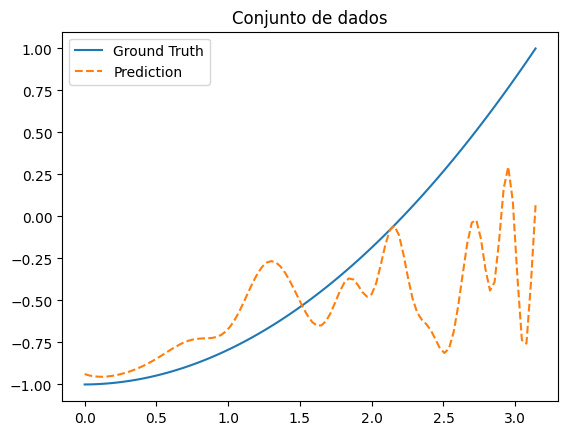

Model (5×4) Training: 100%|██████████| 500/500 [14:54<00:00,  1.79s/it, loss=0.219415]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.122847             Mean squared error of prediction
                    R² Score                  0.133502             Coefficient of determination
                    Training Time (s)         894.775672           Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


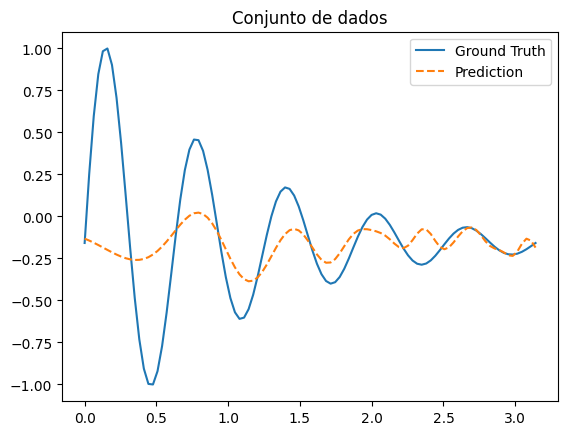

Model (5×4) Training: 100%|██████████| 500/500 [14:55<00:00,  1.79s/it, loss=0.123494]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.050288             Mean squared error of prediction
                    R² Score                  0.593787             Coefficient of determination
                    Training Time (s)         895.166634           Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


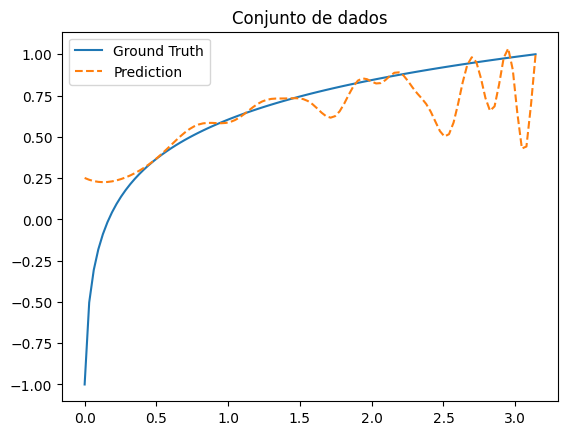

Model (5×4) Training: 100%|██████████| 500/500 [14:53<00:00,  1.79s/it, loss=0.160268]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.094947             Mean squared error of prediction
                    R² Score                  0.551420             Coefficient of determination
                    Training Time (s)         893.558892           Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


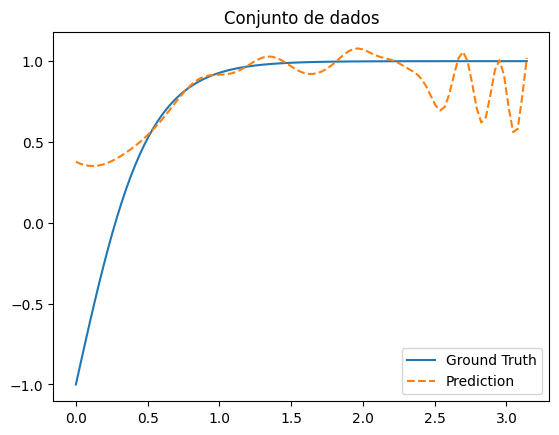

Model (5×4) Training: 100%|██████████| 500/500 [14:53<00:00,  1.79s/it, loss=0.359731]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.203881             Mean squared error of prediction
                    R² Score                  0.400469             Coefficient of determination
                    Training Time (s)         893.892329           Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


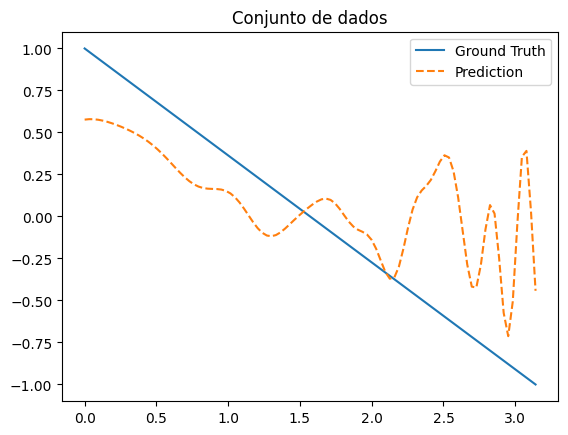

Model (5×4) Training: 100%|██████████| 500/500 [14:57<00:00,  1.79s/it, loss=0.371838]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.186435             Mean squared error of prediction
                    R² Score                  0.472308             Coefficient of determination
                    Training Time (s)         897.197330           Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


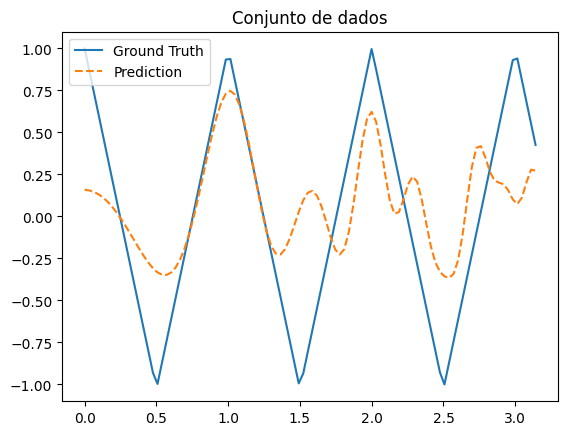

Model (5×4) Training: 100%|██████████| 500/500 [14:53<00:00,  1.79s/it, loss=0.322411]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.184223             Mean squared error of prediction
                    R² Score                  0.445408             Coefficient of determination
                    Training Time (s)         893.971460           Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


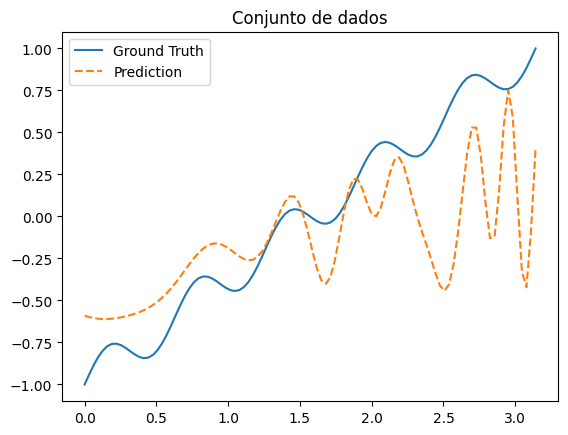

Model (5×4) Training: 100%|██████████| 500/500 [14:56<00:00,  1.79s/it, loss=0.288403]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.242037             Mean squared error of prediction
                    R² Score                  0.268506             Coefficient of determination
                    Training Time (s)         896.380386           Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          4                    Required resources
                    Circuit Depth             9                    Generated circuit complexity
                    


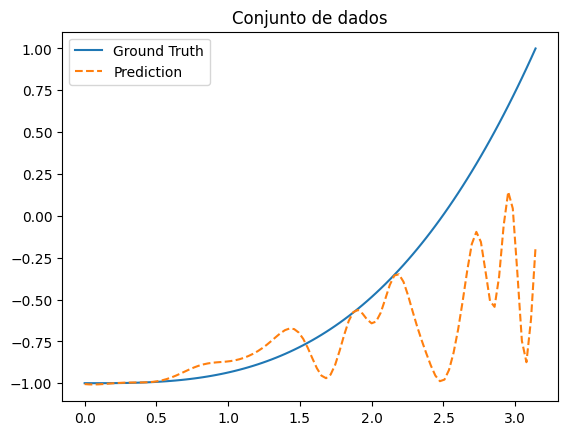

Model (5×5) Training: 100%|██████████| 500/500 [18:19<00:00,  2.20s/it, loss=0.264204]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.172034             Mean squared error of prediction
                    R² Score                  0.494117             Coefficient of determination
                    Training Time (s)         1099.106353          Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


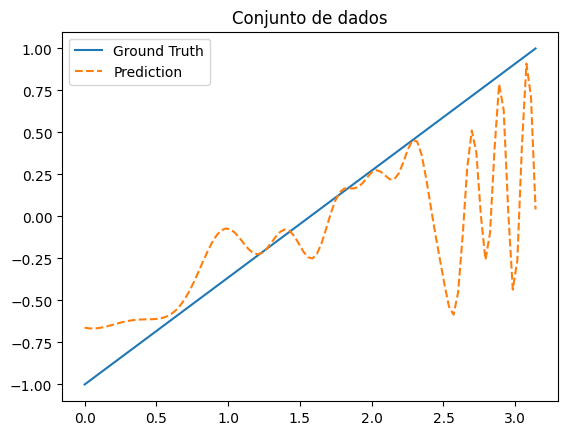

Model (5×5) Training: 100%|██████████| 500/500 [18:21<00:00,  2.20s/it, loss=0.434268]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.289943             Mean squared error of prediction
                    R² Score                  0.414403             Coefficient of determination
                    Training Time (s)         1101.338492          Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


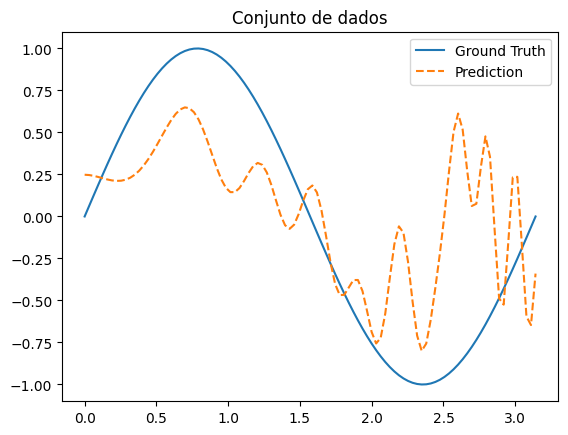

Model (5×5) Training: 100%|██████████| 500/500 [18:18<00:00,  2.20s/it, loss=0.290198]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.217964             Mean squared error of prediction
                    R² Score                  0.399142             Coefficient of determination
                    Training Time (s)         1098.947445          Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


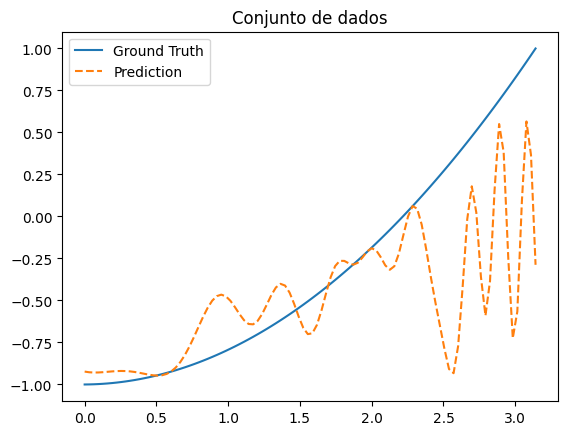

Model (5×5) Training: 100%|██████████| 500/500 [18:21<00:00,  2.20s/it, loss=0.216610]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.103856             Mean squared error of prediction
                    R² Score                  0.267456             Coefficient of determination
                    Training Time (s)         1101.562267          Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


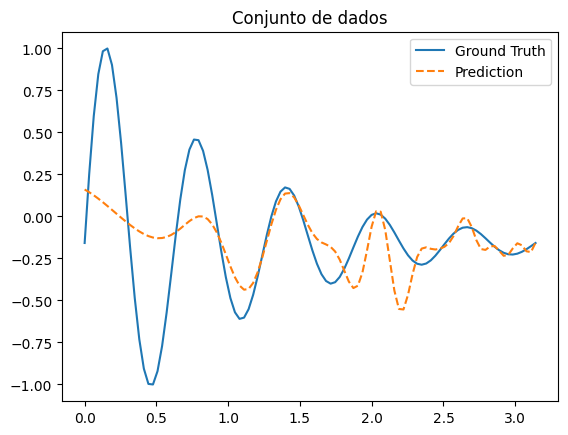

Model (5×5) Training: 100%|██████████| 500/500 [18:19<00:00,  2.20s/it, loss=0.135685]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.055590             Mean squared error of prediction
                    R² Score                  0.550963             Coefficient of determination
                    Training Time (s)         1099.226130          Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


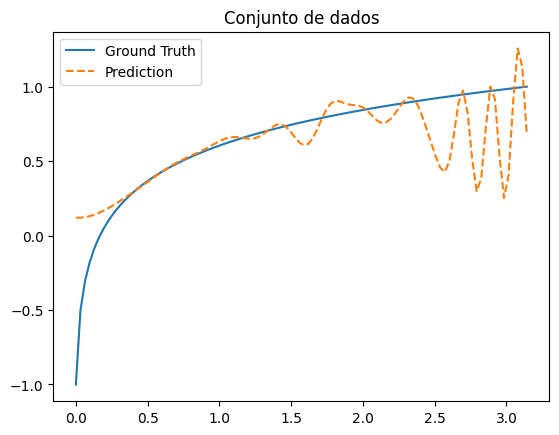

Model (5×5) Training: 100%|██████████| 500/500 [18:20<00:00,  2.20s/it, loss=0.153662]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.075884             Mean squared error of prediction
                    R² Score                  0.641485             Coefficient of determination
                    Training Time (s)         1100.519397          Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


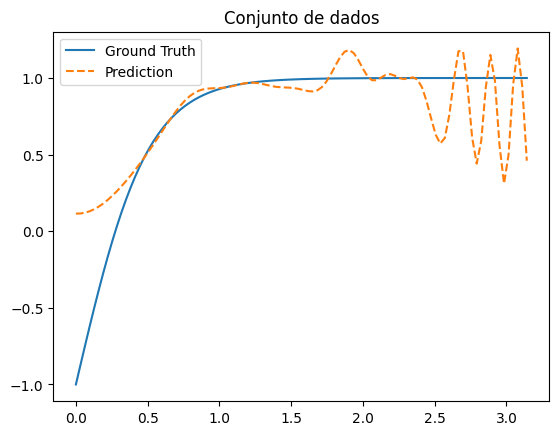

Model (5×5) Training: 100%|██████████| 500/500 [18:21<00:00,  2.20s/it, loss=0.282687]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.200611             Mean squared error of prediction
                    R² Score                  0.410084             Coefficient of determination
                    Training Time (s)         1101.186456          Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


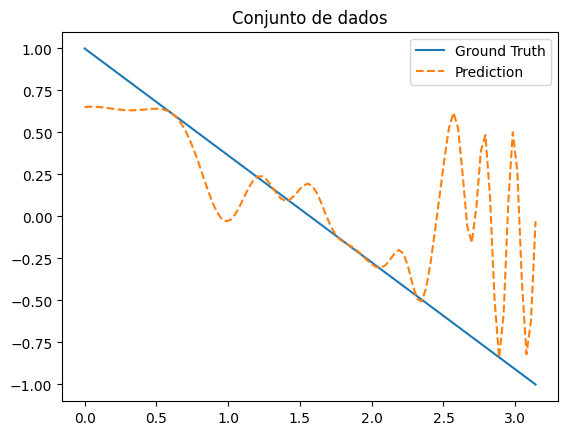

Model (5×5) Training: 100%|██████████| 500/500 [18:22<00:00,  2.20s/it, loss=0.310528]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.152777             Mean squared error of prediction
                    R² Score                  0.567576             Coefficient of determination
                    Training Time (s)         1102.022762          Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


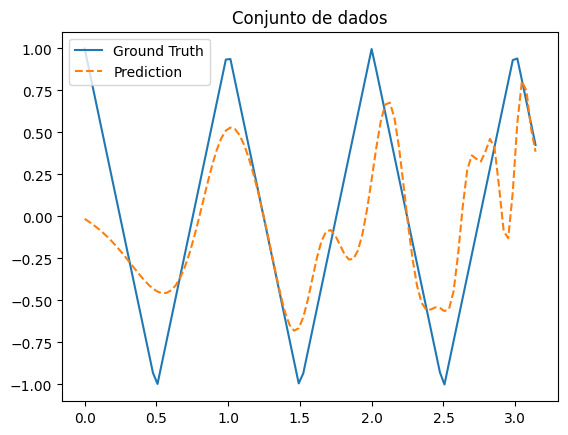

Model (5×5) Training: 100%|██████████| 500/500 [18:21<00:00,  2.20s/it, loss=0.307457]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.222549             Mean squared error of prediction
                    R² Score                  0.330032             Coefficient of determination
                    Training Time (s)         1101.617728          Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


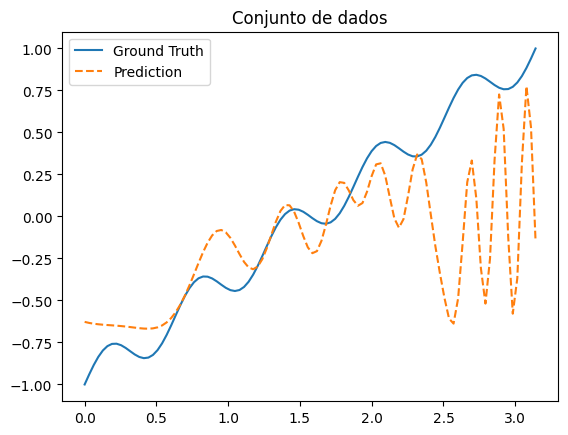

Model (5×5) Training: 100%|██████████| 500/500 [18:22<00:00,  2.21s/it, loss=0.273695]



                    QUANTUM REGRESSOR STATISTICS
                    Metric                    Value                Description
                    --------------------------------------------------------------------------------
                    Mean Squared Error (MSE)  0.184187             Mean squared error of prediction
                    R² Score                  0.443344             Coefficient of determination
                    Training Time (s)         1102.847468          Total training time
                    Number of Qubits          5                    Required resources
                    Number of Layers          5                    Required resources
                    Circuit Depth             11                   Generated circuit complexity
                    


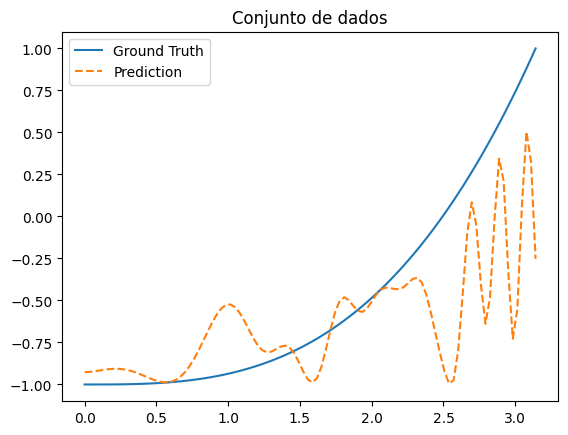

In [ ]:
N=6
result_list = []
for n_qubits in range(1,N):
    for n_layers in range(1,N):
        qaoa_weights = None
        embedding_time = None
        for i in range(len(datasets)):
            dataset = datasets[i]
            fill_columns = np.zeros(len(dataset['x']), dtype = np.float64)
            X = np.column_stack([dataset["x"], dataset["x"]**2,np.sin(dataset["x"]), fill_columns, fill_columns])
            y = dataset["y"]
            X_original = dataset["x"].reshape(-1, 1)
            model = QuantumRegressor(n_qubits=n_qubits, n_layers=n_layers, dataset_idx=i, qaoa_weights=qaoa_weights, embedding_time = embedding_time)
            #model.plot_circuit()

            limitX = n_qubits if n_qubits < X.shape[1] else 5
            model.fit(X=X[:,:limitX],y=y,epochs=500)

            y_pred = model.predict(X[:,:limitX])

            results = model.stats(y_pred,y,verbose=True)
            result_list.append(results)
            write_csv(result_list)

            plt.title("Conjunto de dados")
            plt.plot(X_original, y, label="Ground Truth")
            plt.plot(X_original, y_pred, '--', label="Prediction")
            plt.legend()
            plt.show()
            
            #Para o próximo dataset não será necessário treinar o embedding
            qaoa_weights = model.qaoa_weights 
            embedding_time = model.embedding_time

In [18]:
def matrix_view(axis1: str, axis2: str, value: str, df: pd.DataFrame,additional_text = "",precision=1):
    """
    Gera uma matriz de confusão com coloração baseada em intensidade.

    Parâmetros:
    - axis1: nome da coluna para o eixo y (ex: "real")
    - axis2: nome da coluna para o eixo x (ex: "previsto")
    - value: nome da coluna com os valores (ex: "frequência")
    - df: DataFrame contendo essas colunas
    - mode: 'higher' para intensidade proporcional ao valor alto,
            'lower' para intensidade proporcional ao valor baixo
    """

    cmap = sns.light_palette("xkcd:copper", 10)

    # Pivotar o DataFrame
    matrix = df.pivot_table(index=axis1, columns=axis2, values=value, aggfunc='mean', fill_value=0)

    # Plotar heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=f".{precision}f", cmap=cmap, linewidths=0.5, linecolor='gray')
    plt.title(f"{axis1.replace('_',' ')}×{axis2.replace('_',' ')} - {value.replace('_',' ')} {additional_text}")
    plt.ylabel(axis1)
    plt.xlabel(axis2)
    plt.tight_layout()
    plt.show()

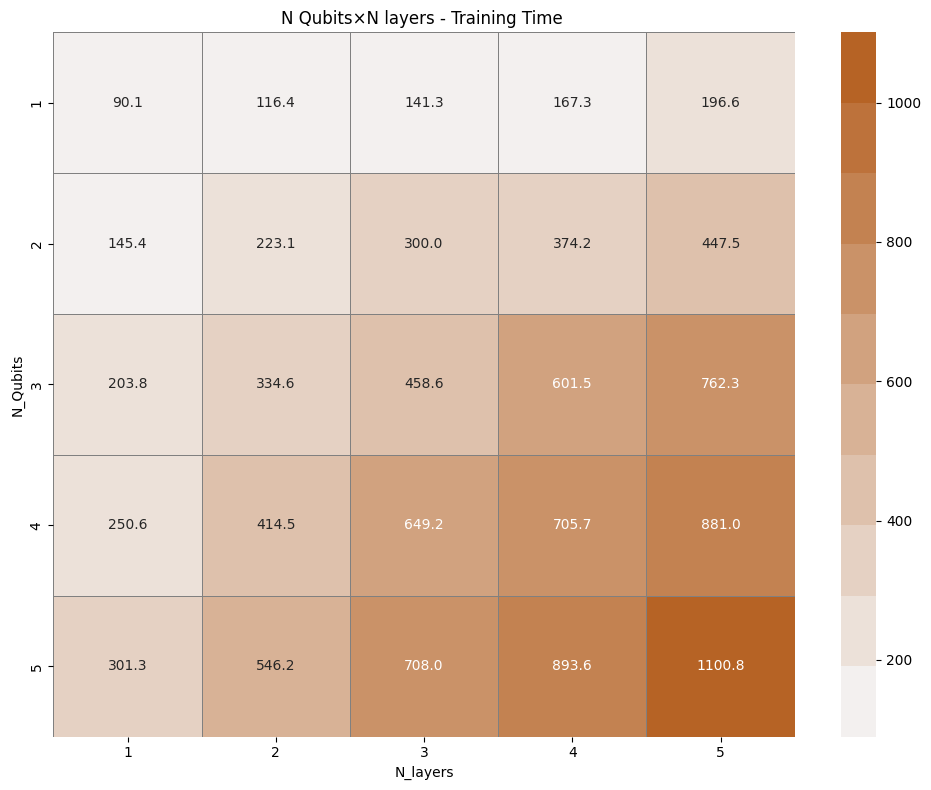

In [23]:
result_df = pd.read_csv("qaoa_lightning.csv", sep=",", encoding="utf-8")
matrix_view("N_Qubits","N_layers","Training_Time",df =result_df)

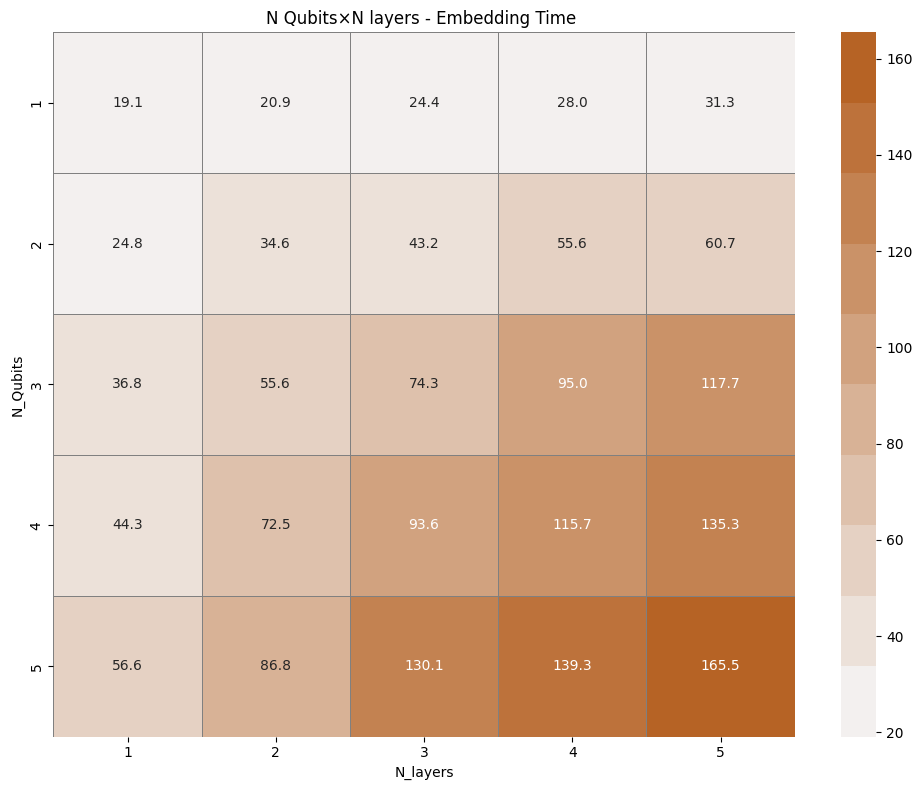

In [24]:
result_df = pd.read_csv("qaoa_lightning.csv", sep=",", encoding="utf-8")
matrix_view("N_Qubits","N_layers","Embedding_Time",df =result_df)

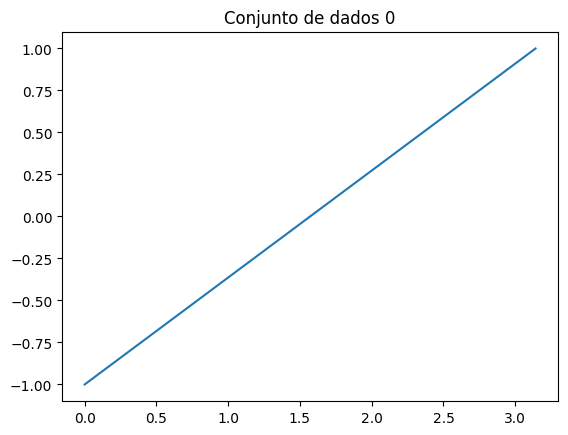

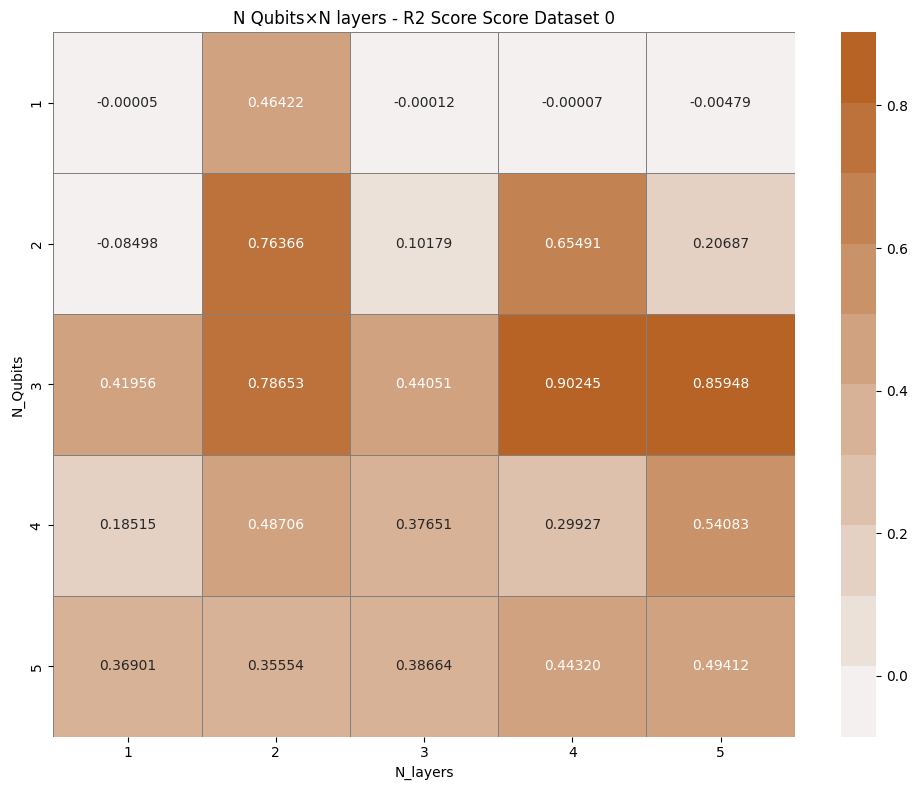

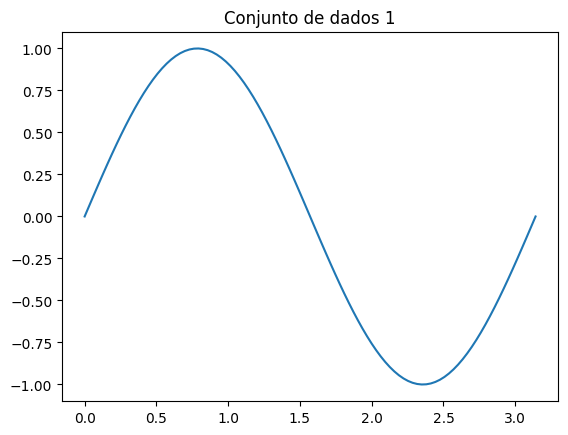

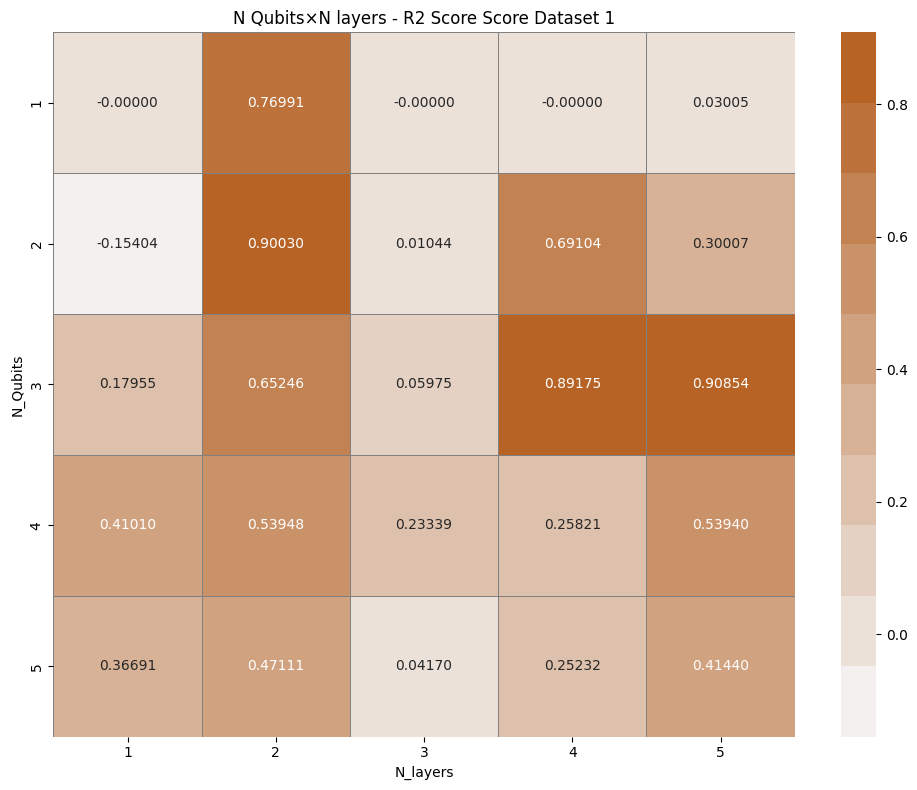

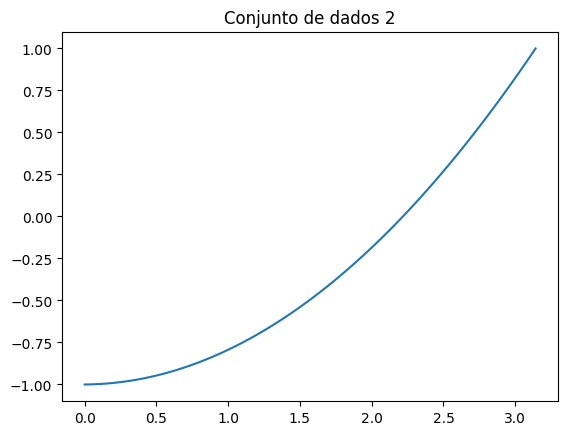

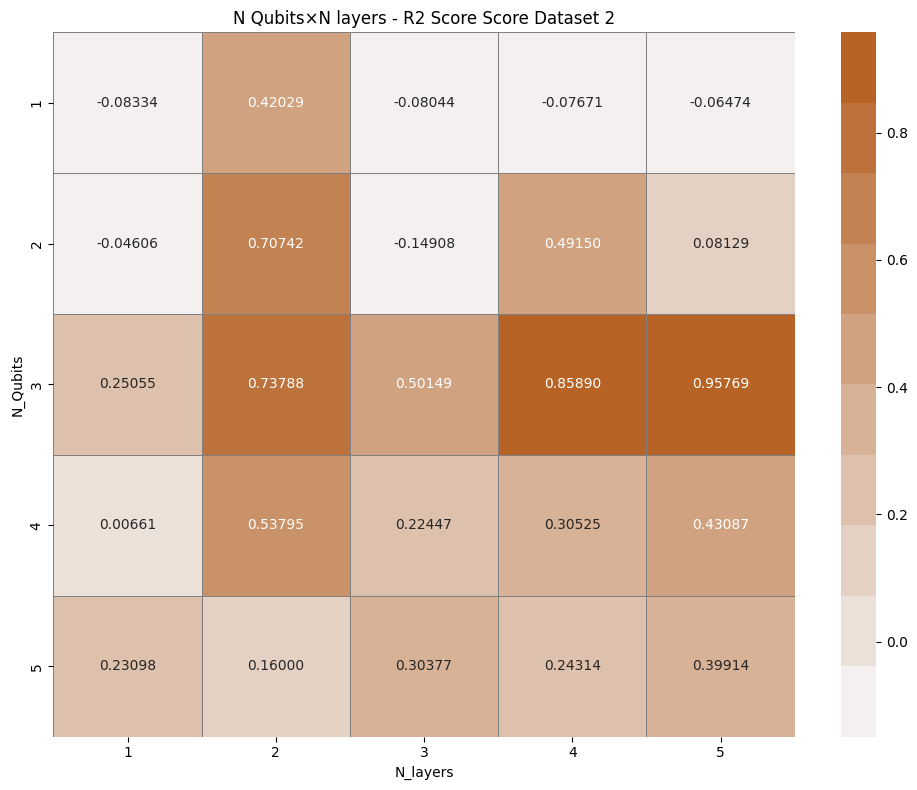

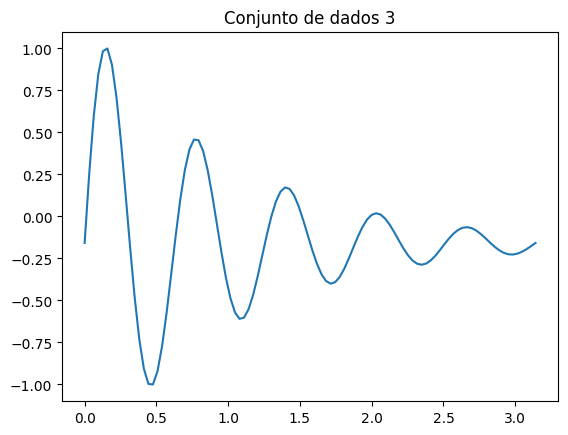

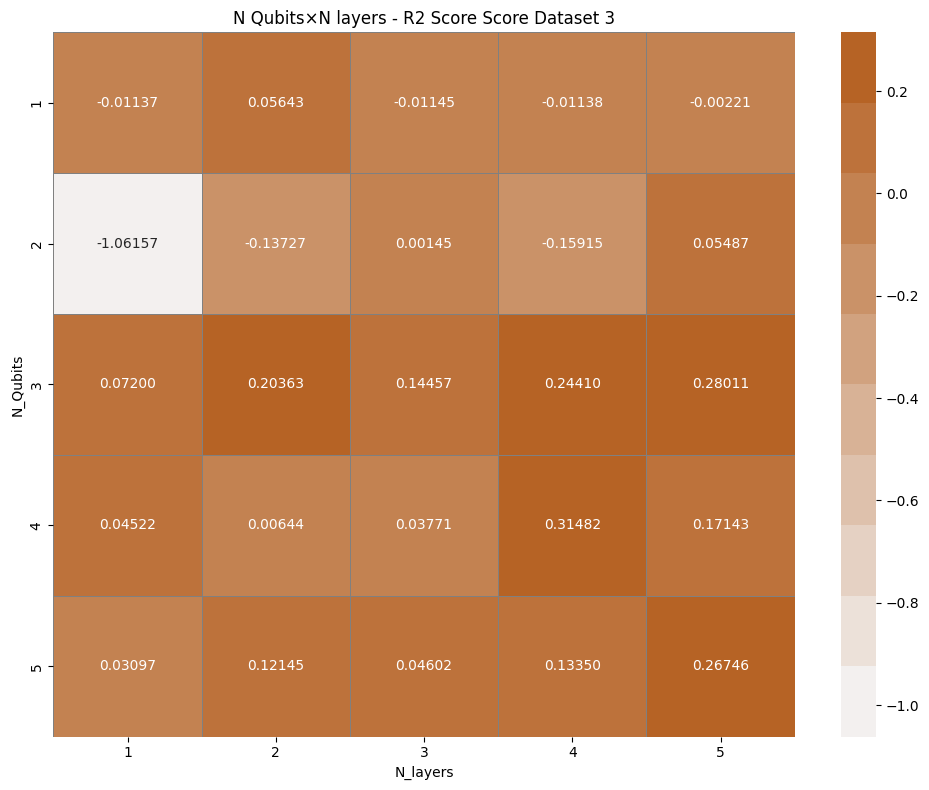

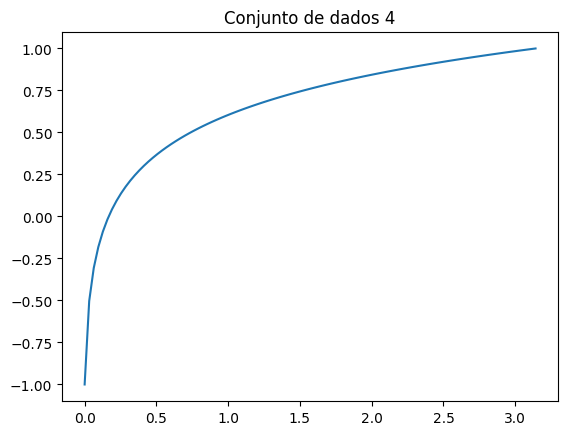

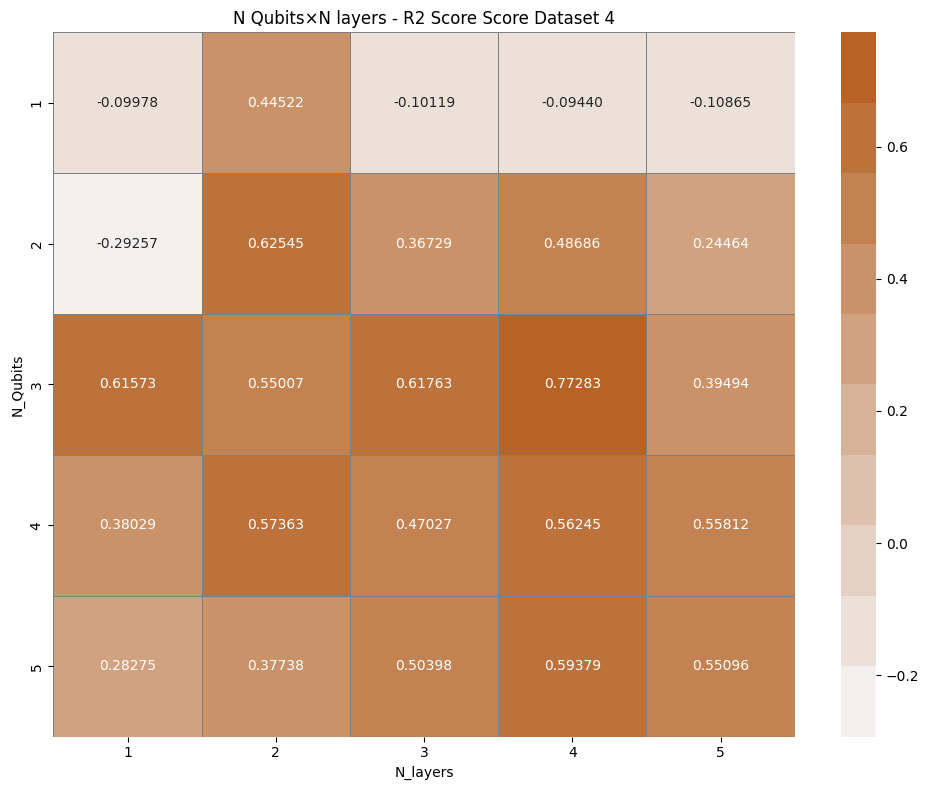

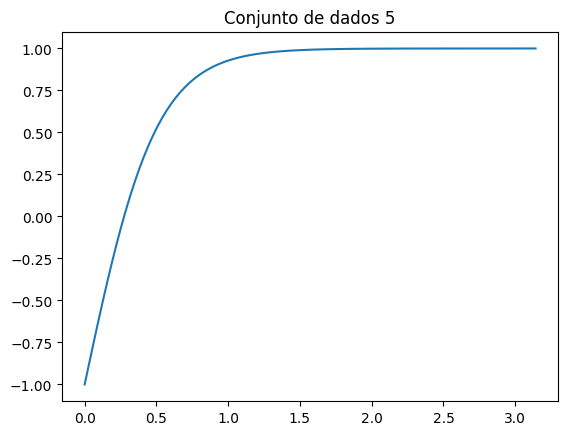

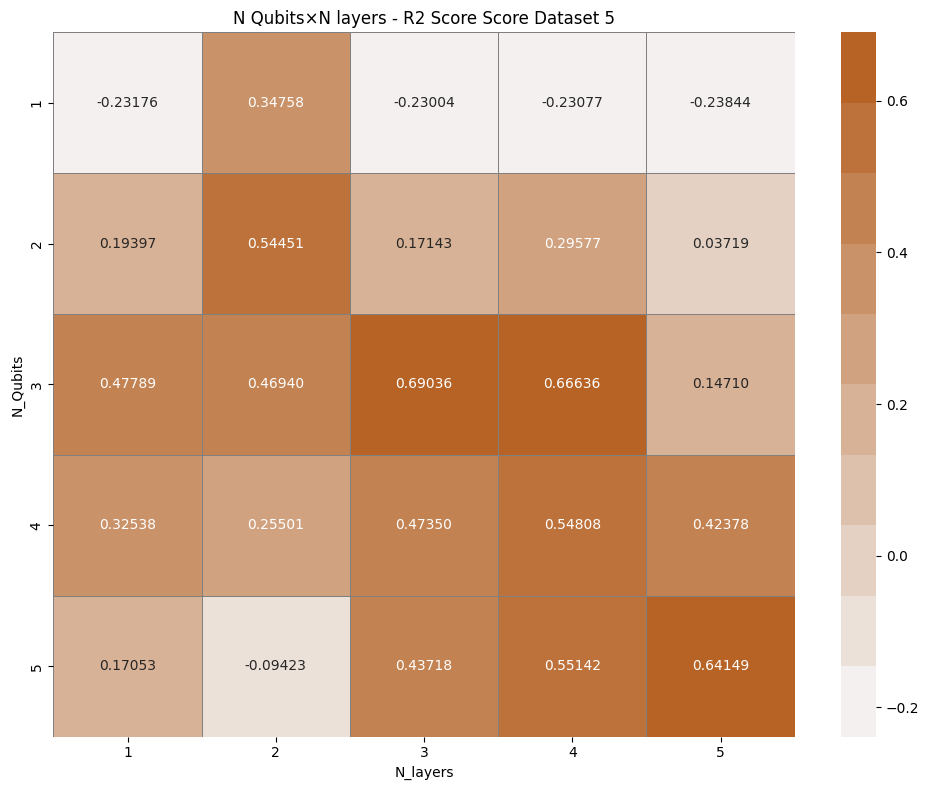

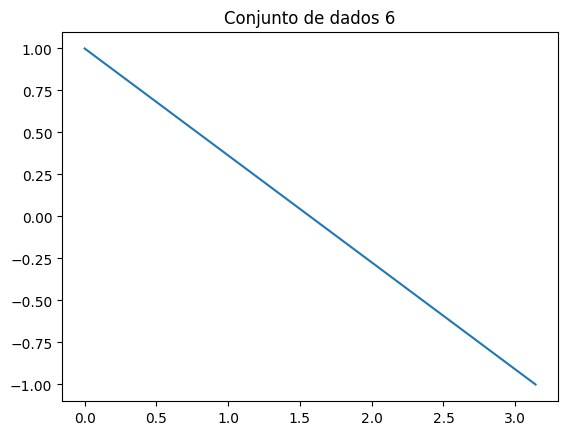

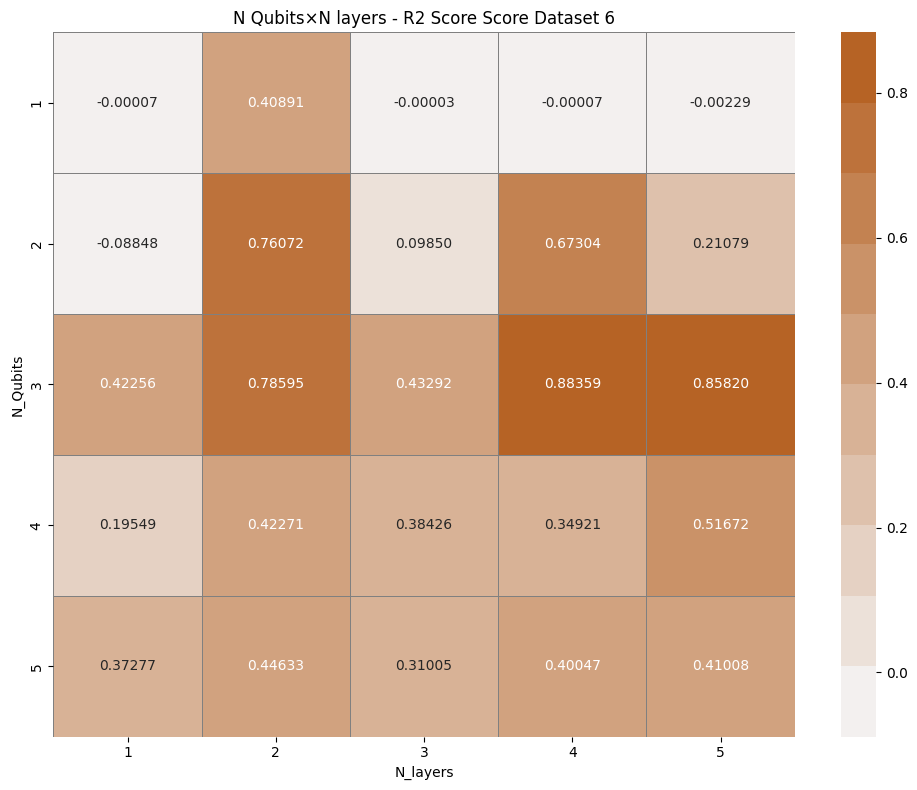

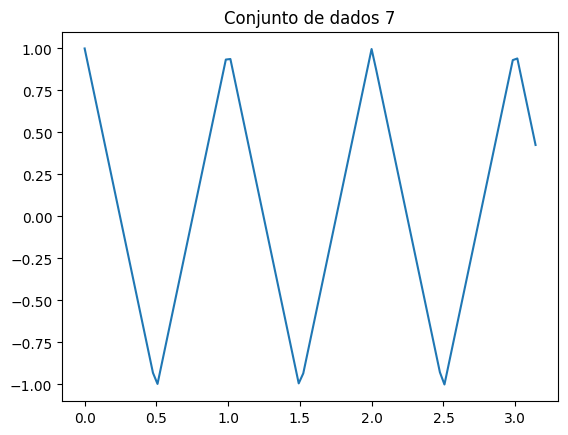

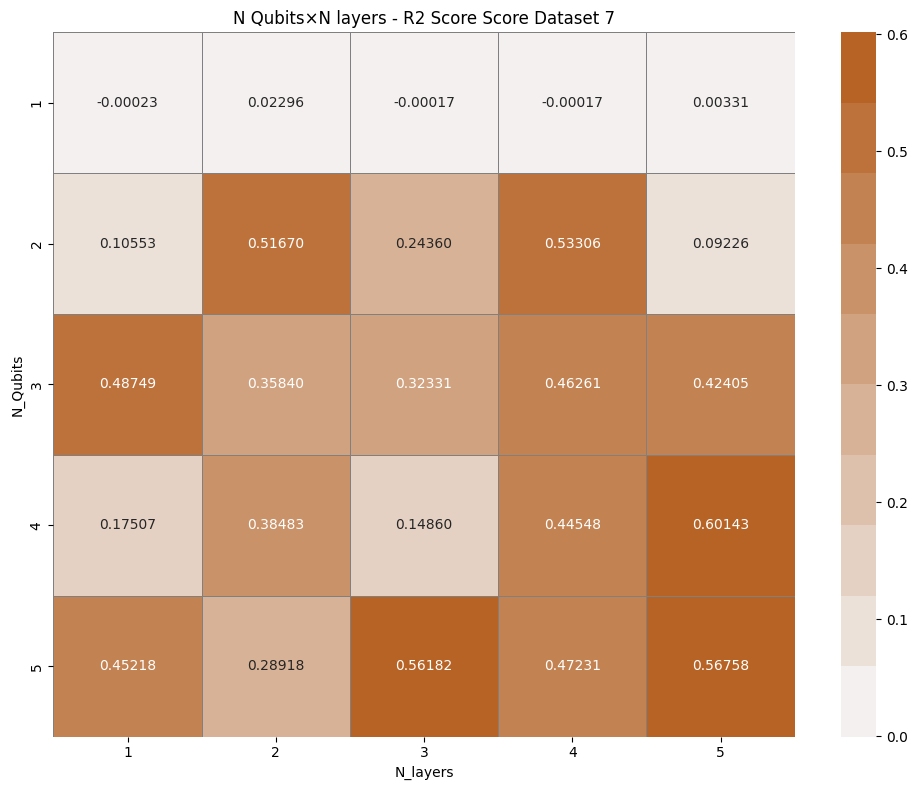

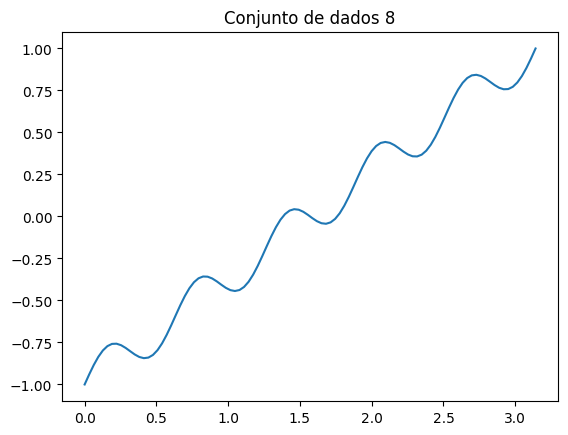

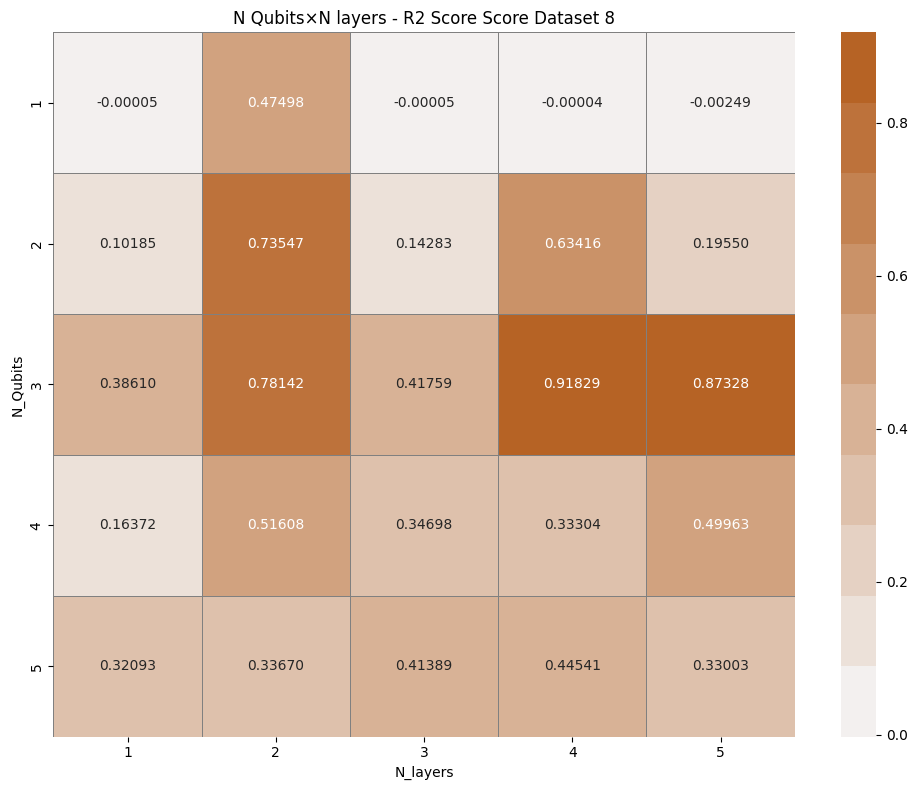

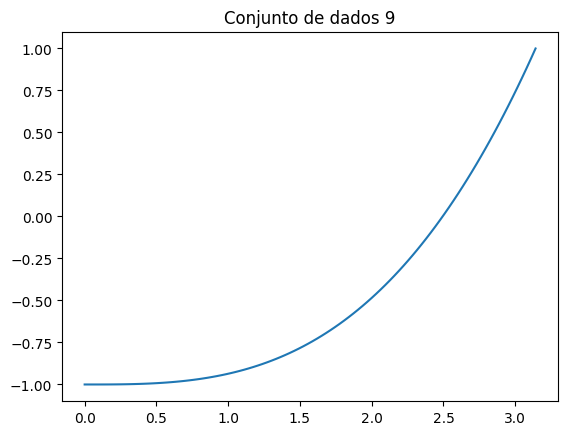

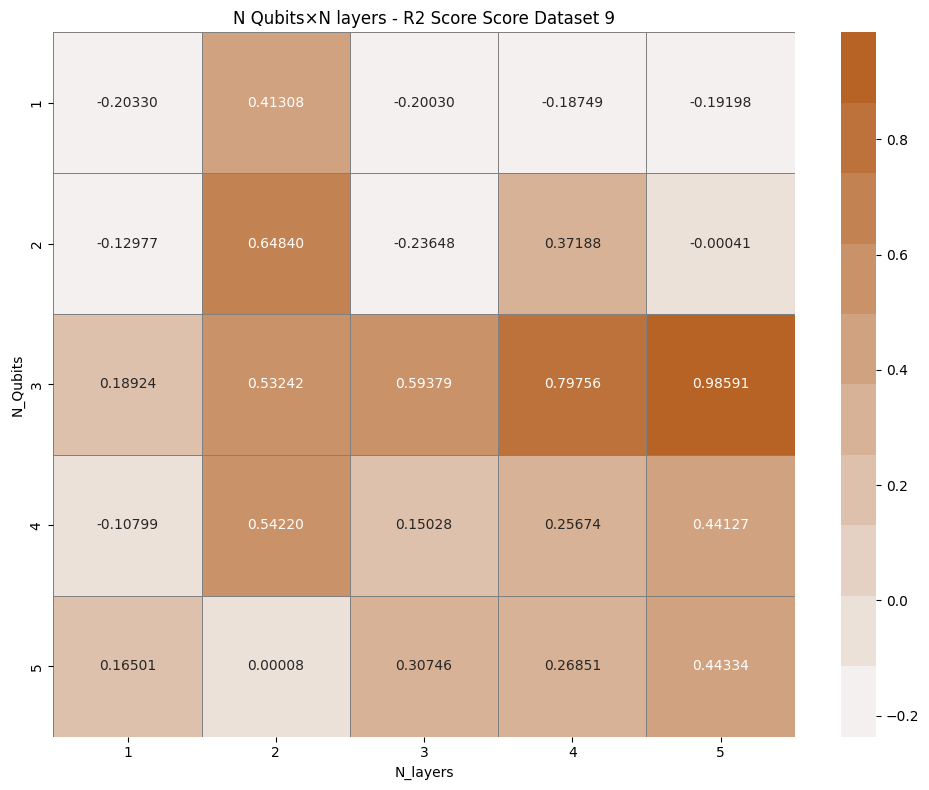

In [26]:
for i in datasets:
    plt.title(f"Conjunto de dados {i}")
    plt.plot(datasets[i]['x'], datasets[i]['y'])
    plt.show()

    view_df = result_df[result_df["Dataset_Index"]==i]
    matrix_view("N_Qubits","N_layers","R2_Score",df =view_df,additional_text=f"Score Dataset {i}",precision=5)
    plt.show()

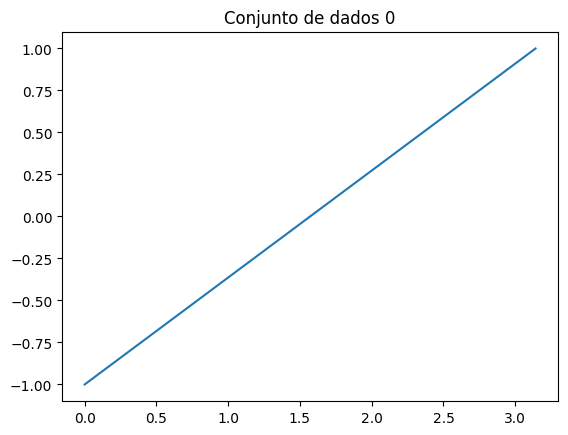

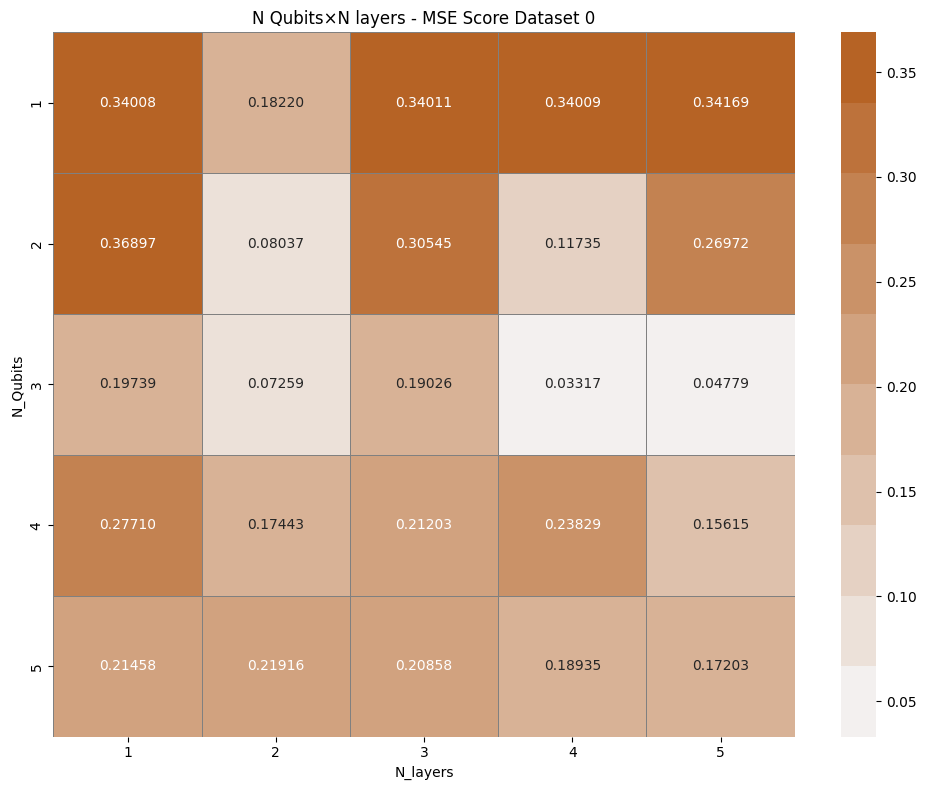

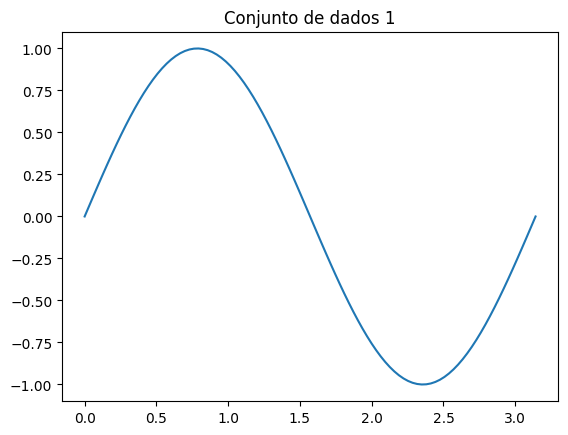

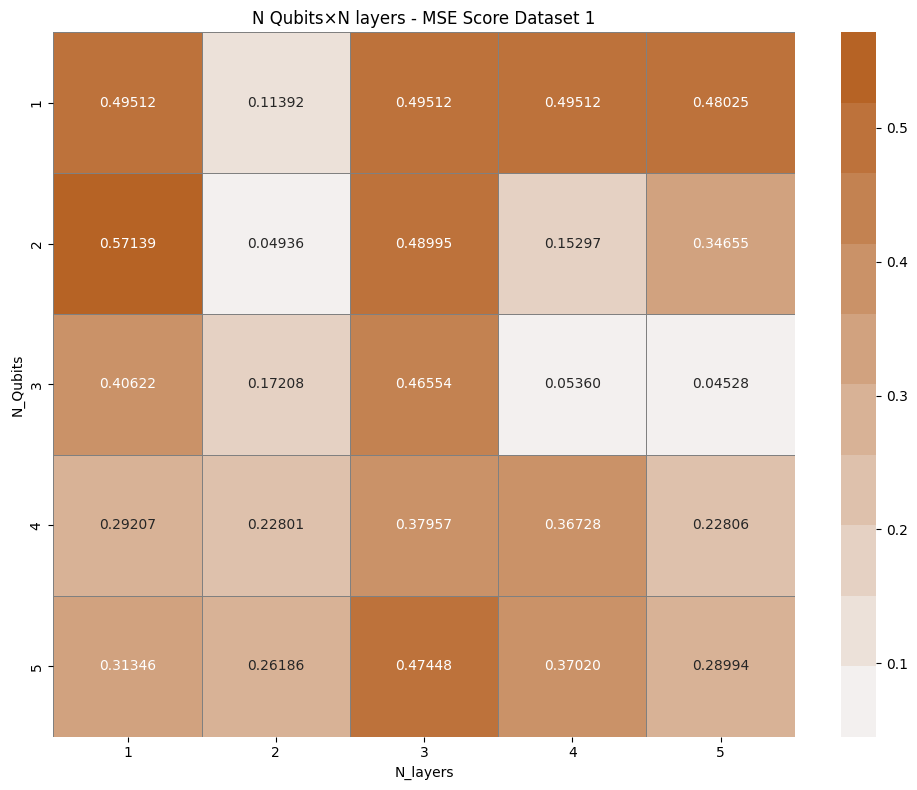

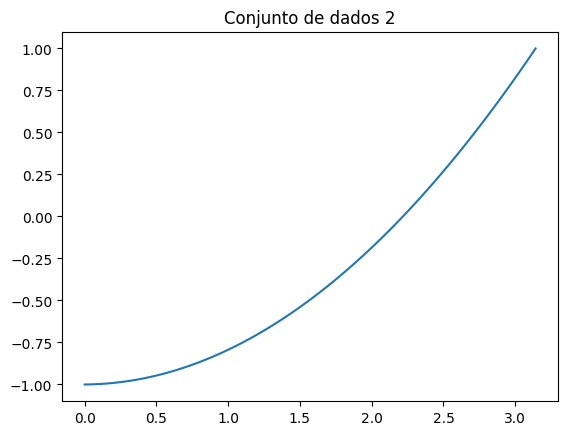

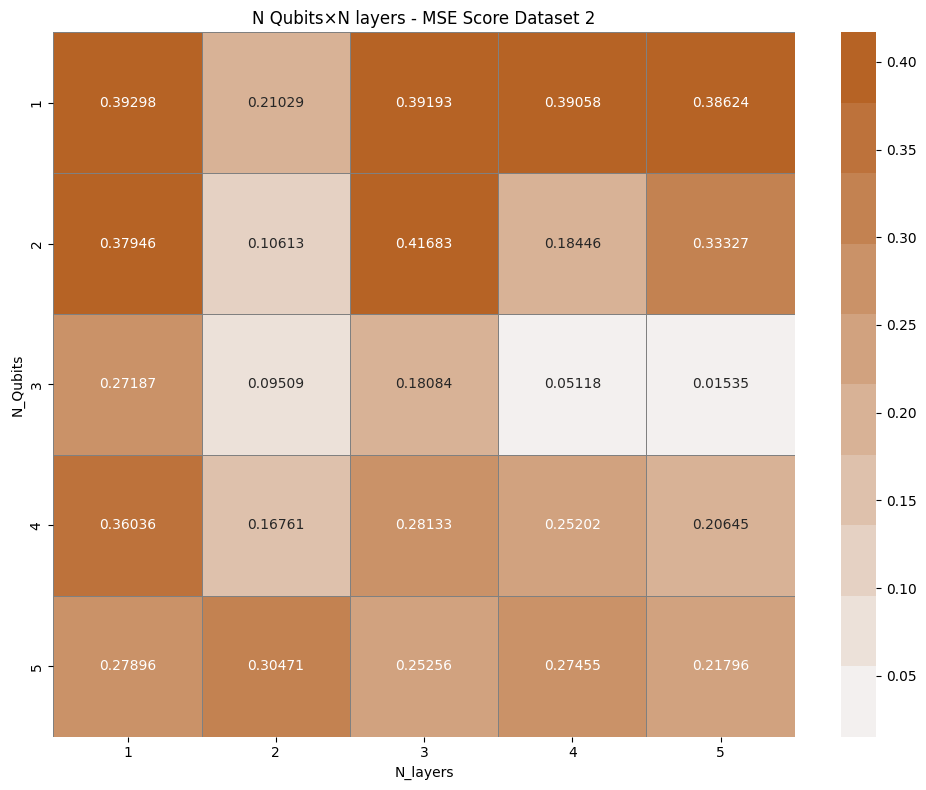

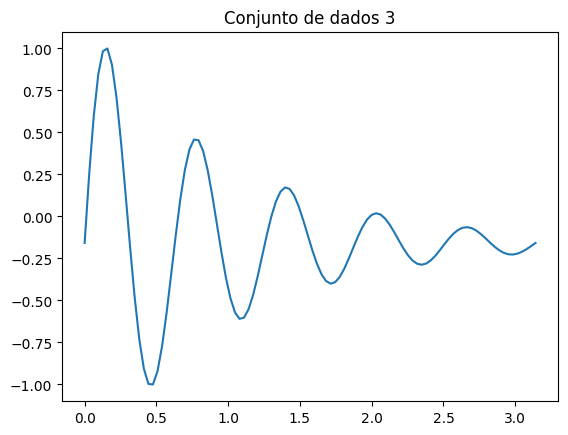

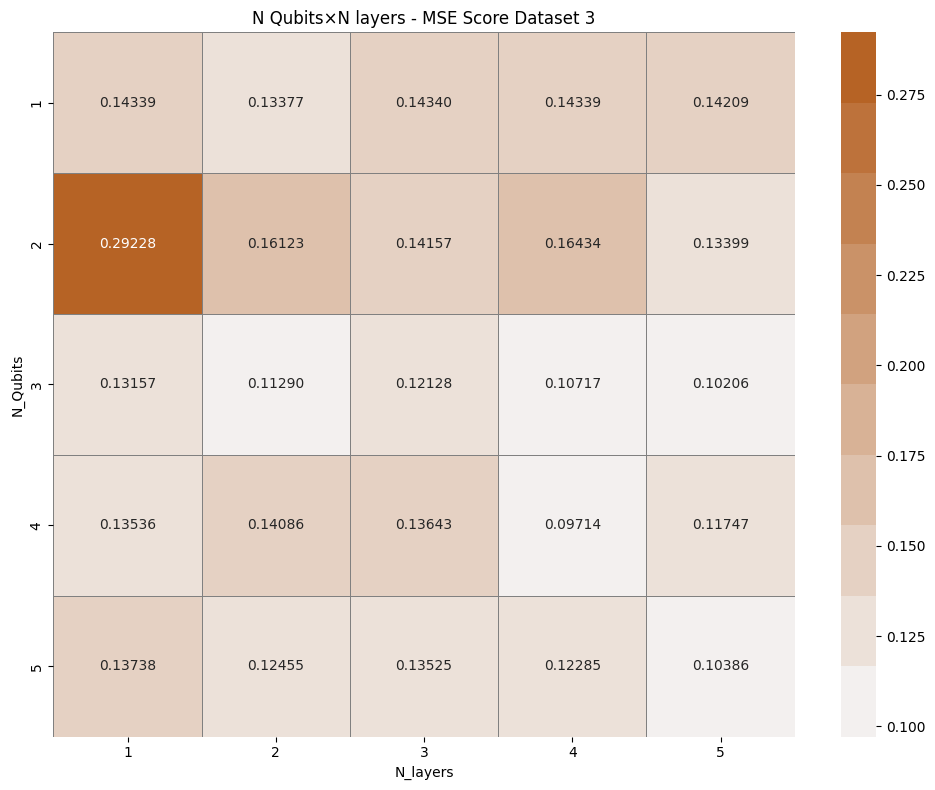

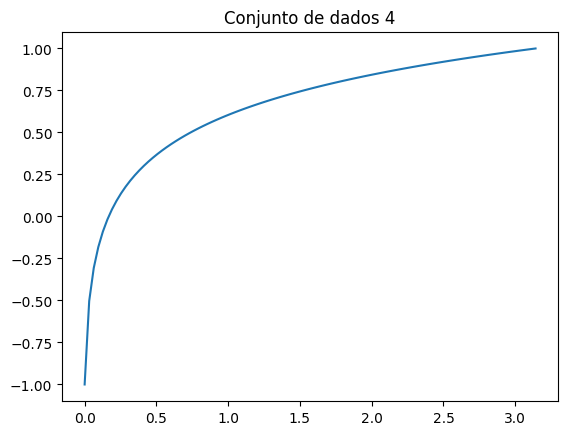

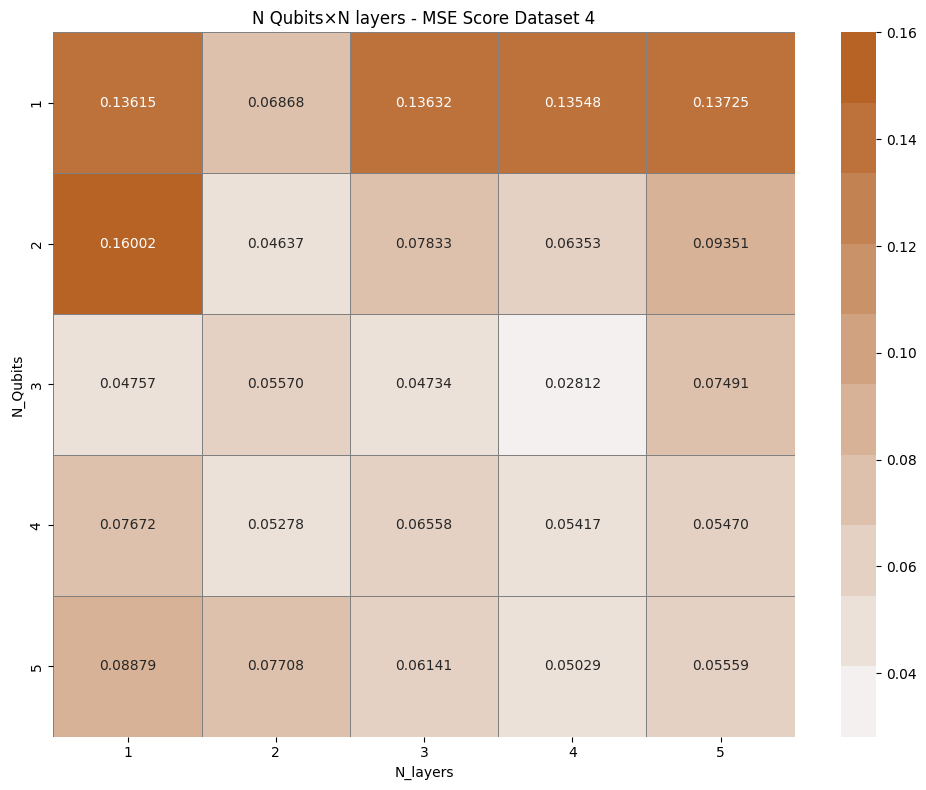

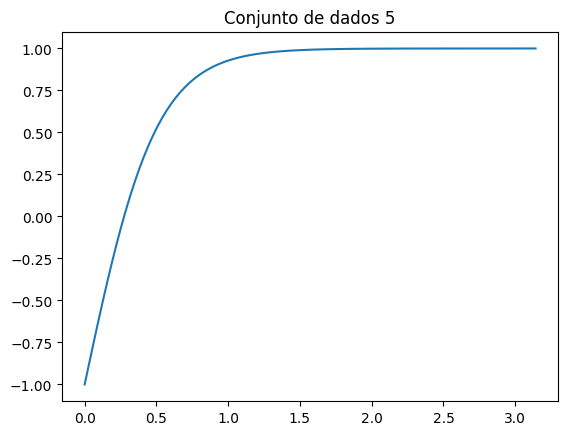

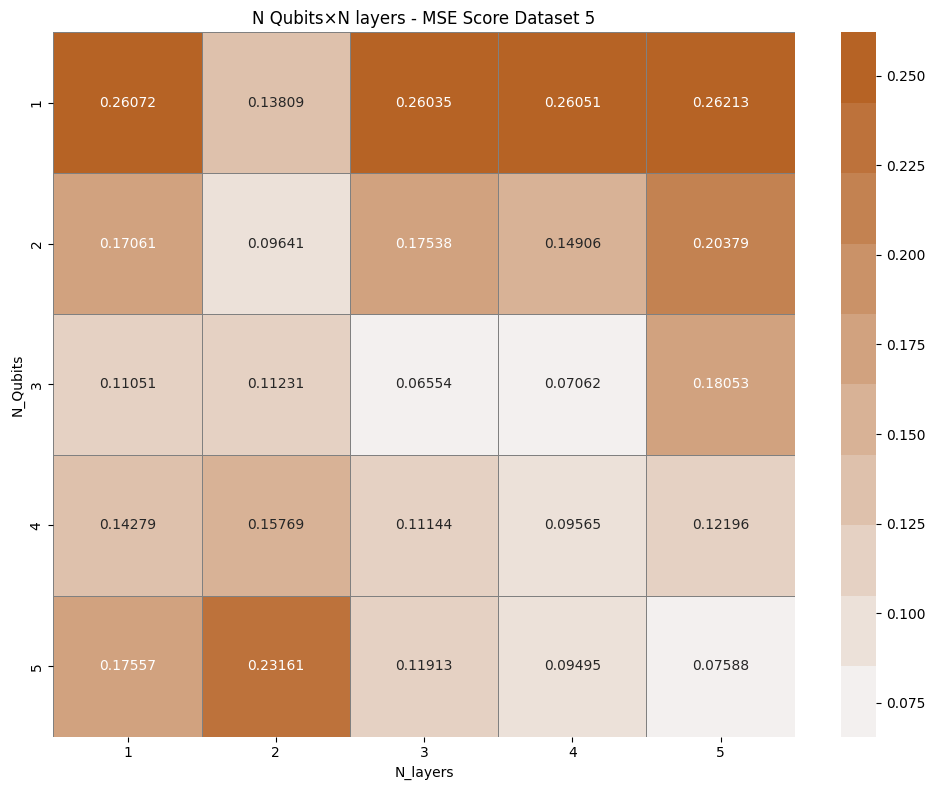

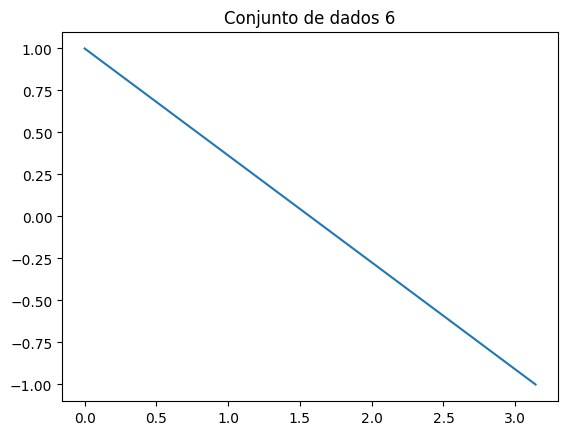

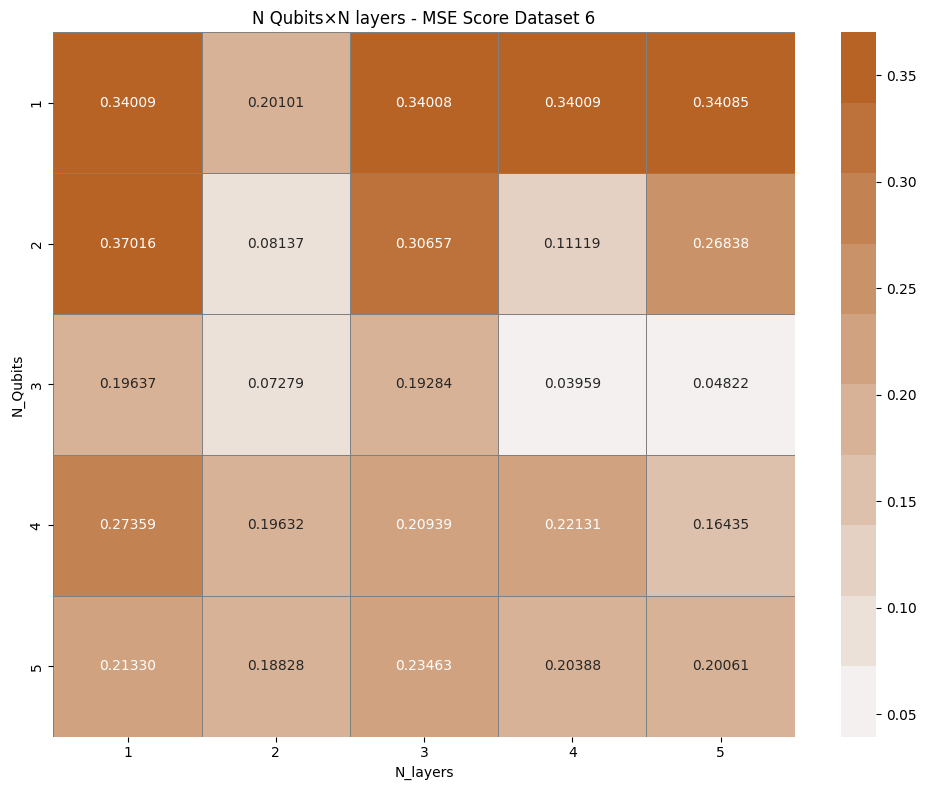

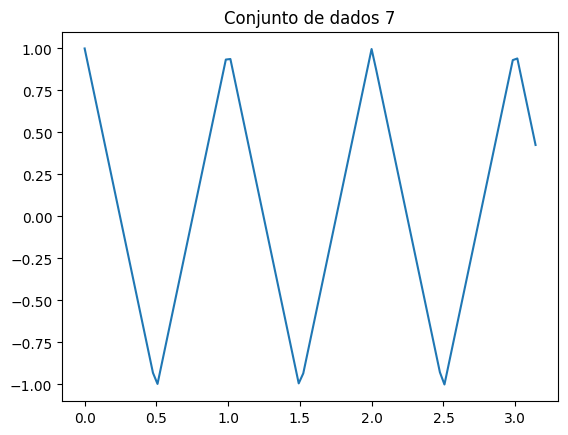

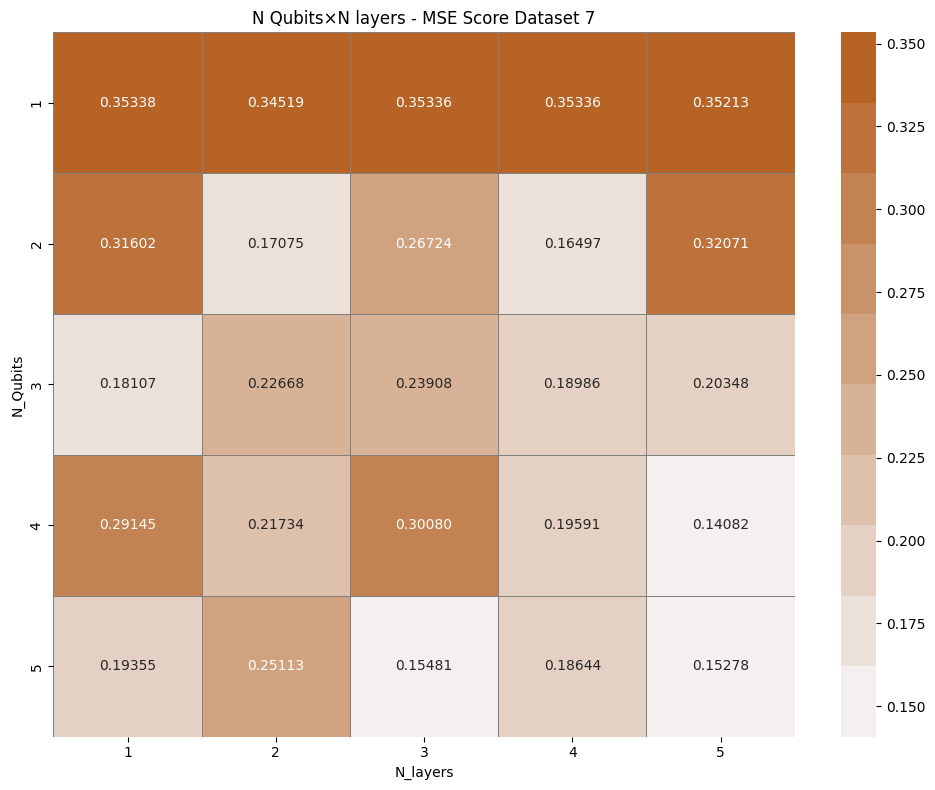

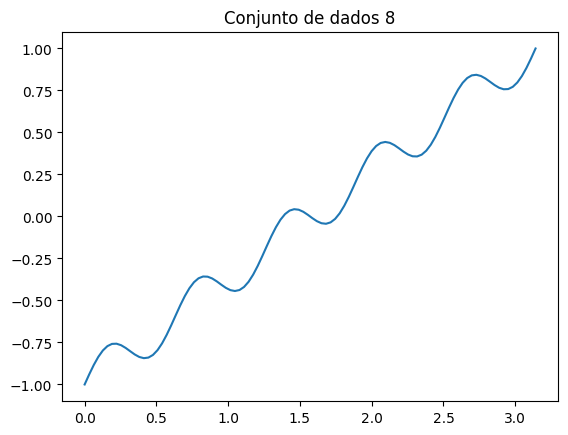

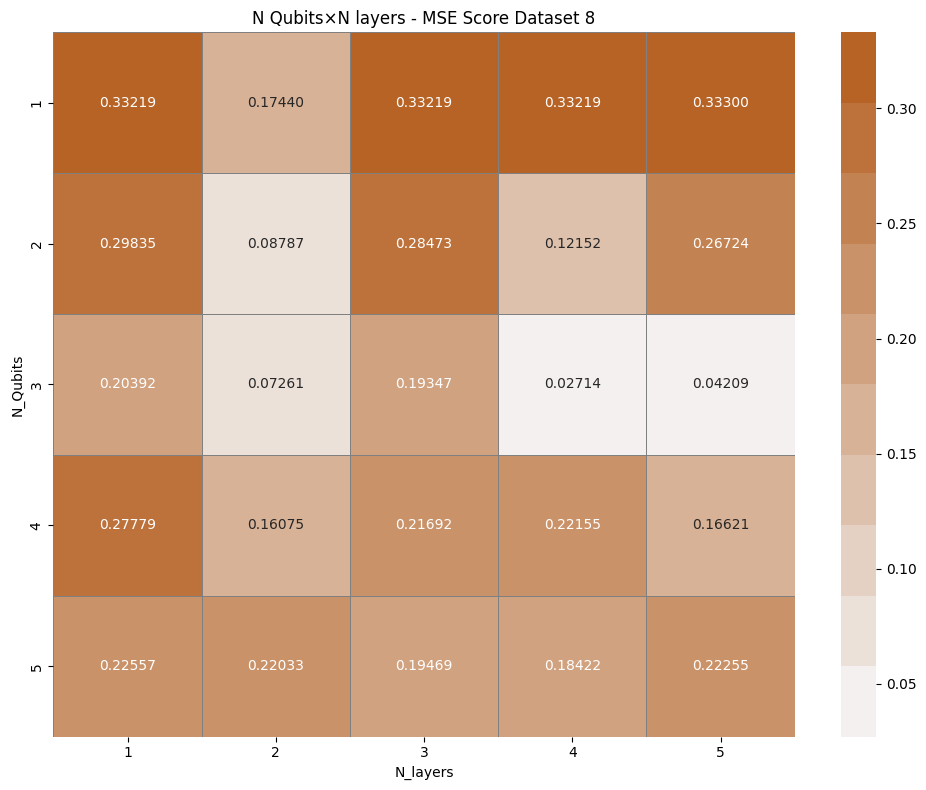

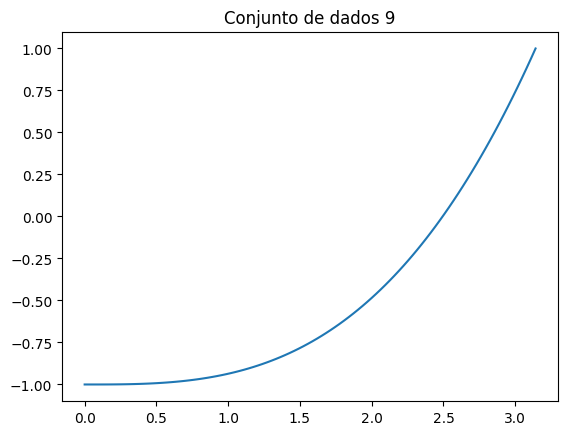

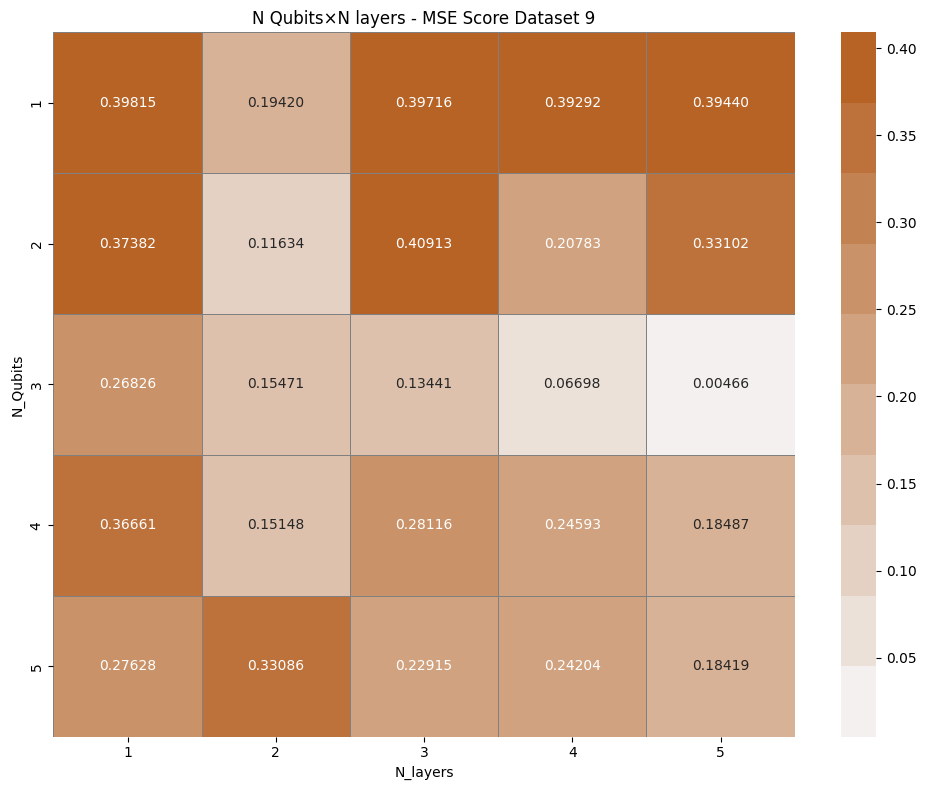

In [27]:
for i in datasets:
    plt.title(f"Conjunto de dados {i}")
    plt.plot(datasets[i]['x'], datasets[i]['y'])
    plt.show()

    view_df = result_df[result_df["Dataset_Index"]==i]
    matrix_view("N_Qubits","N_layers","MSE",df =view_df,additional_text=f"Score Dataset {i}",precision=5)
    plt.show()